# 데이터 처리 환경 구성

In [1]:
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, random, datetime, time
import collections

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from matplotlib import font_manager, rc
from matplotlib import style
style.use('ggplot')
%matplotlib inline

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

sns.set(font=font_name,
        rc={"axes.unicode_minus":False})

pd.set_option('display.max_rows', 220)
pd.set_option('display.max_columns', 20)

## 분석 함수 정의
* 값의 차이가 많이 나기 때문에 정규화

In [2]:
def score_normalize(lst):
    normalized=[]
    scaler = MinMaxScaler()
    normalized=scaler.fit_transform(lst)
    
    return normalized

In [3]:
# method / kmeans 더 효율적으로 쓰는 것 
def elbow(X,n,seed=1192):
    sse = []
    for i in range(1,n+1):
        print("\r",i,"/",n,end='') # r: rewrite, end: 줄 바뀜 없애기
        km = KMeans(n_clusters=i,init='k-means++',random_state=seed)
        km.fit(X)
        sse.append(km.inertia_)
    plt.figure(figsize=(20,10))
    plt.plot(range(1,n+1),sse,marker='o')
    plt.ylabel("SSE")
    plt.show()

In [4]:
def K_means(data):
    km = KMeans(n_clusters=3, n_jobs=-1, random_state=seed)
    km.fit(data)
    res= km.predict(data)
    data[res==0], data[res==1], data[res==2] 

## 트랜드 분석이란
* 트랜드 분석- 상향식, 하향식
    * 상향식 : 기깔나게 경향을 찾아서, 그 경향에 맞는 애들을 빼고 남은 애들에서 또 찾음(그룹화, 비지도-군집화, 범주형)

# 연령대, 성별 코로나와 가장 밀접한 관련이 있는 사업은?
* 전체 사업의 그래프와 그 사업의 그래프의 MinMaxScaler를 하여 차이를 구해보자


## 데이터 불러오기
* 원본 데이터 저장

In [5]:
path = './data'
ori_Samsungcard=pd.read_csv(path+'/Samsungcard.csv', encoding='cp949')
ori_Shinhancard=pd.read_excel(path+'/Shinhancard.xlsx')

ori_Gin_price=pd.read_csv(path+'/GIN00009A.csv')
ori_Gin_trade_vol=pd.read_csv(path+'/GIN00008A.csv')
ori_Gin_loc=pd.read_json(path+'/center_GIN00010M.json')

ori_Mbn=pd.read_excel(path+'./mk_news_201901_202006.xlsx')

ori_M_corper=pd.read_csv(path+'/M_corper.csv')
ori_card=pd.read_csv(path+'/Card.csv')

In [6]:
ori_Shinhancard=ori_Shinhancard.drop(columns=['Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7']).copy()

In [7]:
# m_path = path+'/Mcorporation/상품 카테고리 데이터_KDX 시각화 경진대회 Only'
# m_list=os.listdir(m_path)

# for i in range(1,5):
#     display(pd.read_excel(m_path+'/'+m_list[i]))

# ori_M_corper=pd.concat([pd.read_excel(m_path+'/'+i) for i in m_list[1:]])
# ori_M_corper.to_csv('./data/M_corper.csv')

In [8]:
# Samsungcard.columns=['일별','업종','성별','연령대별','소비건수(천건)']
# Samsungcard['소비건수(천건)']=round(Samsungcard['소비건수(천건)']/1000,1)
# Samsungcard[['일별','성별','연령대별','업종','소비건수(천건)']]
# Samsungcard['성별'] = Samsungcard['성별'].apply(lambda x: 'M' if x=='남성' else 'F')

## 상관관계 저장
* save_corr(spe_list)

In [9]:
def save_corr(k):
    for i in range(len(k)):
        plt.figure(figsize=(20,10))
        print(spe_list[i])
        before_card_all=card_all[(card_all['일자']<2020010)&(card_all['일자']>=2019070)]
        before_card_gp=card_gp[(card_gp['일자']<2020010)&(card_gp['일자']>=2019070)]
        all_before=before_card_all[before_card_all['업종']==spe_list[i]]
        all_before['건수_정규화']=score_normalize(np.array(before_card_all[before_card_all['업종']==spe_list[i]]['건수']).reshape(-1,1))
        for j in age_list:
            all_before[str(j)+'_정규화']=score_normalize(np.array(before_card_gp[(before_card_gp['연령']==j)&(before_card_gp['업종']==spe_list[i])]['건수']).reshape(-1,1))
        set_all_before=all_before[['건수_정규화','20_정규화','30_정규화','40_정규화','50_정규화','60_정규화']]
        mask = np.triu(np.ones_like(set_all_before.corr(), dtype=np.bool))

        plt.subplot(1,2,1)
        plt.title(spe_list[i]+' 코로나 전')
        sns.heatmap(set_all_before.corr(), annot=True, cmap="Blues", mask=mask)

        after_card_all=card_all[(card_all['일자']>=2020010)]
        after_card_gp=card_gp[(card_gp['일자']>=2020010)]
        all_after=after_card_all[after_card_all['업종']==spe_list[i]]
        all_after['건수_정규화']=score_normalize(np.array(after_card_all[after_card_all['업종']==spe_list[i]]['건수']).reshape(-1,1))
        for k in age_list:
            all_after[str(k)+'_정규화']=score_normalize(np.array(after_card_gp[(after_card_gp['연령']==k)&(after_card_gp['업종']==spe_list[i])]['건수']).reshape(-1,1))
        select_all_after=all_after[['건수_정규화','20_정규화','30_정규화','40_정규화','50_정규화','60_정규화']]
        mask = np.triu(np.ones_like(select_all_after.corr(), dtype=np.bool))

        plt.subplot(1,2,2)
        plt.title('코로나 후')
        sns.heatmap(select_all_after.corr(), annot=True, cmap="Blues", mask=mask)
        plt.savefig('save'+str(i)+'.png')
        plt.show()

### 원본 데이터를 Copy. 
* 작업하다가 꼬이면 이 줄만 시행하면 되기에 **꼭** 해줘야하는 작업임.

In [23]:
Samsungcard = ori_Samsungcard.copy()
Shinhancard = ori_Shinhancard.copy()

Gin_price = ori_Gin_price.copy()
Gin_trade_vol = ori_Gin_trade_vol.copy()
Gin_loc = ori_Gin_loc.copy()

Mbn_news = ori_Mbn.copy()
M_corper = ori_M_corper.copy()

card=ori_card.copy()

In [24]:
# card data 쓰기 좋게 정리
card['소비건수']=card['소비건수(삼성)']+card['소비건수(신한)']
# card['소비일자']=pd.to_datetime(card['소비일자'].astype(str))
card=card[['소비일자','소비업종','성별','연령대','소비건수']].copy()
card.columns=['일자','업종','성별','연령','건수']

### 월별 상관관계 분석

In [12]:
card['일자']=card['일자'].apply(lambda x: int(str(x)[:6]))
card_gp=card.groupby(['일자','업종','성별','연령']).sum().reset_index().copy()

card_gp['성별'] = card_gp['성별'].apply(lambda x: 'M' if x==1 else 'F').copy()
# card_gp['연령'] = card_gp['연령'].apply(lambda x: str(x)+'대').copy()

card_gp=card_gp.groupby(['일자','업종','연령']).sum().reset_index()

spe_list=card_gp['업종'].unique().tolist()
age_list=card_gp['연령'].unique().tolist()

card_gp['건수']=np.round(card_gp['건수']).astype(int)
card_all=card_gp.groupby(['일자','업종']).sum().reset_index()

In [13]:
def corr_per_month(spe):
    all_select=card_all[card_all['업종']==spe]
    all_select['건수_정규화']=score_normalize(np.array(card_all[card_all['업종']==spe]['건수']).reshape(-1,1))
    for i in age_list:
        all_select[str(i)+'_정규화']=score_normalize(np.array(card_gp[(card_gp['연령']==i)&(card_gp['업종']==spe)]['건수']).reshape(-1,1))
    set_all_select=all_select[['건수_정규화','20_정규화','30_정규화','40_정규화','50_정규화','60_정규화']]
    corr=set_all_select.corr()
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    sns.heatmap(corr, annot=True, cmap="Blues", mask=mask)
    plt.show()

In [14]:
def corr_per_month_before_corona(spe):
    select_card_all=card_all[(card_all['일자']<=201912)]
    select_card_gp=card_gp[(card_gp['일자']<=201912)]
    all_select=select_card_all[select_card_all['업종']==spe]
    all_select['건수_정규화']=score_normalize(np.array(select_card_all[select_card_all['업종']==spe]['건수']).reshape(-1,1))
    for i in age_list:
        all_select[str(i)+'_정규화']=score_normalize(np.array(select_card_gp[(select_card_gp['연령']==i)&(select_card_gp['업종']==spe)]['건수']).reshape(-1,1))
    set_all_select=all_select[['건수_정규화','20_정규화','30_정규화','40_정규화','50_정규화','60_정규화']]
    corr=set_all_select.corr()
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    sns.heatmap(corr, annot=True, cmap="Blues", mask=mask)
    plt.show()

In [15]:
def corr_per_month_after_corona(spe):
    select_card_all=card_all[(card_all['일자']>201912)]
    select_card_gp=card_gp[(card_gp['일자']>201912)]
    all_select=select_card_all[select_card_all['업종']==spe]
    all_select['건수_정규화']=score_normalize(np.array(select_card_all[select_card_all['업종']==spe]['건수']).reshape(-1,1))
    for i in age_list:
        all_select[str(i)+'_정규화']=score_normalize(np.array(select_card_gp[(select_card_gp['연령']==i)&(select_card_gp['업종']==spe)]['건수']).reshape(-1,1))
    set_all_select=all_select[['건수_정규화','20_정규화','30_정규화','40_정규화','50_정규화','60_정규화']]
    corr=set_all_select.corr()
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    sns.heatmap(corr, annot=True, cmap="Blues", mask=mask)
    plt.show()

In [16]:
for i in spe_list:
    print(i)
    print('<전체>')
    corr_per_month(i)
    print('<코로나 전>')
    corr_per_month_before_corona(i)
    print('<코로나 후>')
    corr_per_month_after_corona(i)

가전/가구
<전체>


NameError: name 'find_corr' is not defined

### 주별 상관관계 분석

In [ ]:
card['일자']=card['일자'].apply(lambda x: int(str(x)[:7]))
card_gp=card.groupby(['일자','업종','성별','연령']).sum().reset_index().copy()

card_gp['성별'] = card_gp['성별'].apply(lambda x: 'M' if x==1 else 'F').copy()
# card_gp['연령'] = card_gp['연령'].apply(lambda x: str(x)+'대').copy()

card_gp=card_gp.groupby(['일자','업종','연령']).sum().reset_index()

spe_list=card_gp['업종'].unique().tolist()
age_list=card_gp['연령'].unique().tolist()

card_gp['건수']=np.round(card_gp['건수']).astype(int)
card_all=card_gp.groupby(['일자','업종']).sum().reset_index()

for i in range(len(card_all)):
    if str(card_all['일자'][i])[-1]=='3':
        card_all.drop(i, inplace=True)
        
for i in range(len(card_gp)):
    if str(card_gp['일자'][i])[-1]=='3':
        card_gp.drop(i, inplace=True)
        
card_all=card_all.reset_index()
card_gp=card_gp.reset_index()

In [ ]:
def corr_per_week(spe):
    all_select=card_all[card_all['업종']=='가전/가구']
    all_select['건수_정규화']=score_normalize(np.array(card_all[card_all['업종']=='가전/가구']['건수']).reshape(-1,1))
    for i in age_list:
        all_select[str(i)+'_정규화']=score_normalize(np.array(card_gp[(card_gp['연령']==i)&(card_gp['업종']=='가전/가구')]['건수']).reshape(-1,1))

    set_all_select=all_select[['건수_정규화','20_정규화','30_정규화','40_정규화','50_정규화','60_정규화']]
    corr=set_all_select.corr()
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    sns.heatmap(corr, annot=True, cmap="Blues", mask=mask)
    plt.show()

In [ ]:
def corr_per_week_before_corona(spe):
    select_card_all=card_all[(card_all['일자']<2020012)]
    select_card_gp=card_gp[(card_gp['일자']<2020012)]
    all_select=select_card_all[select_card_all['업종']==spe]
    all_select['건수_정규화']=score_normalize(np.array(select_card_all[select_card_all['업종']==spe]['건수']).reshape(-1,1))
    for i in age_list:
        all_select[str(i)+'_정규화']=score_normalize(np.array(select_card_gp[(select_card_gp['연령']==i)&(select_card_gp['업종']==spe)]['건수']).reshape(-1,1))
    set_all_select=all_select[['건수_정규화','20_정규화','30_정규화','40_정규화','50_정규화','60_정규화']]
    corr=set_all_select.corr()
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    sns.heatmap(corr, annot=True, cmap="Blues", mask=mask)
    plt.show()

In [ ]:
def corr_per_week_with_corona(spe):
    select_card_all=card_all[(card_all['일자']>=2020012)]
    select_card_gp=card_gp[(card_gp['일자']>=2020012)]
    all_select=select_card_all[select_card_all['업종']==spe]
    all_select['건수_정규화']=score_normalize(np.array(select_card_all[select_card_all['업종']==spe]['건수']).reshape(-1,1))
    for i in age_list:
        all_select[str(i)+'_정규화']=score_normalize(np.array(select_card_gp[(select_card_gp['연령']==i)&(select_card_gp['업종']==spe)]['건수']).reshape(-1,1))
    set_all_select=all_select[['건수_정규화','20_정규화','30_정규화','40_정규화','50_정규화','60_정규화']]
    corr=set_all_select.corr()
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    sns.heatmap(corr, annot=True, cmap="Blues", mask=mask)
    plt.show()

In [ ]:
for i in spe_list:
    print(i)
    print('<전체>')
    corr_per_week(i)
    print('<코로나 전>')
    corr_per_week_before_corona(i)
    print('<코로나 후>')
    corr_per_week_with_corona(i)

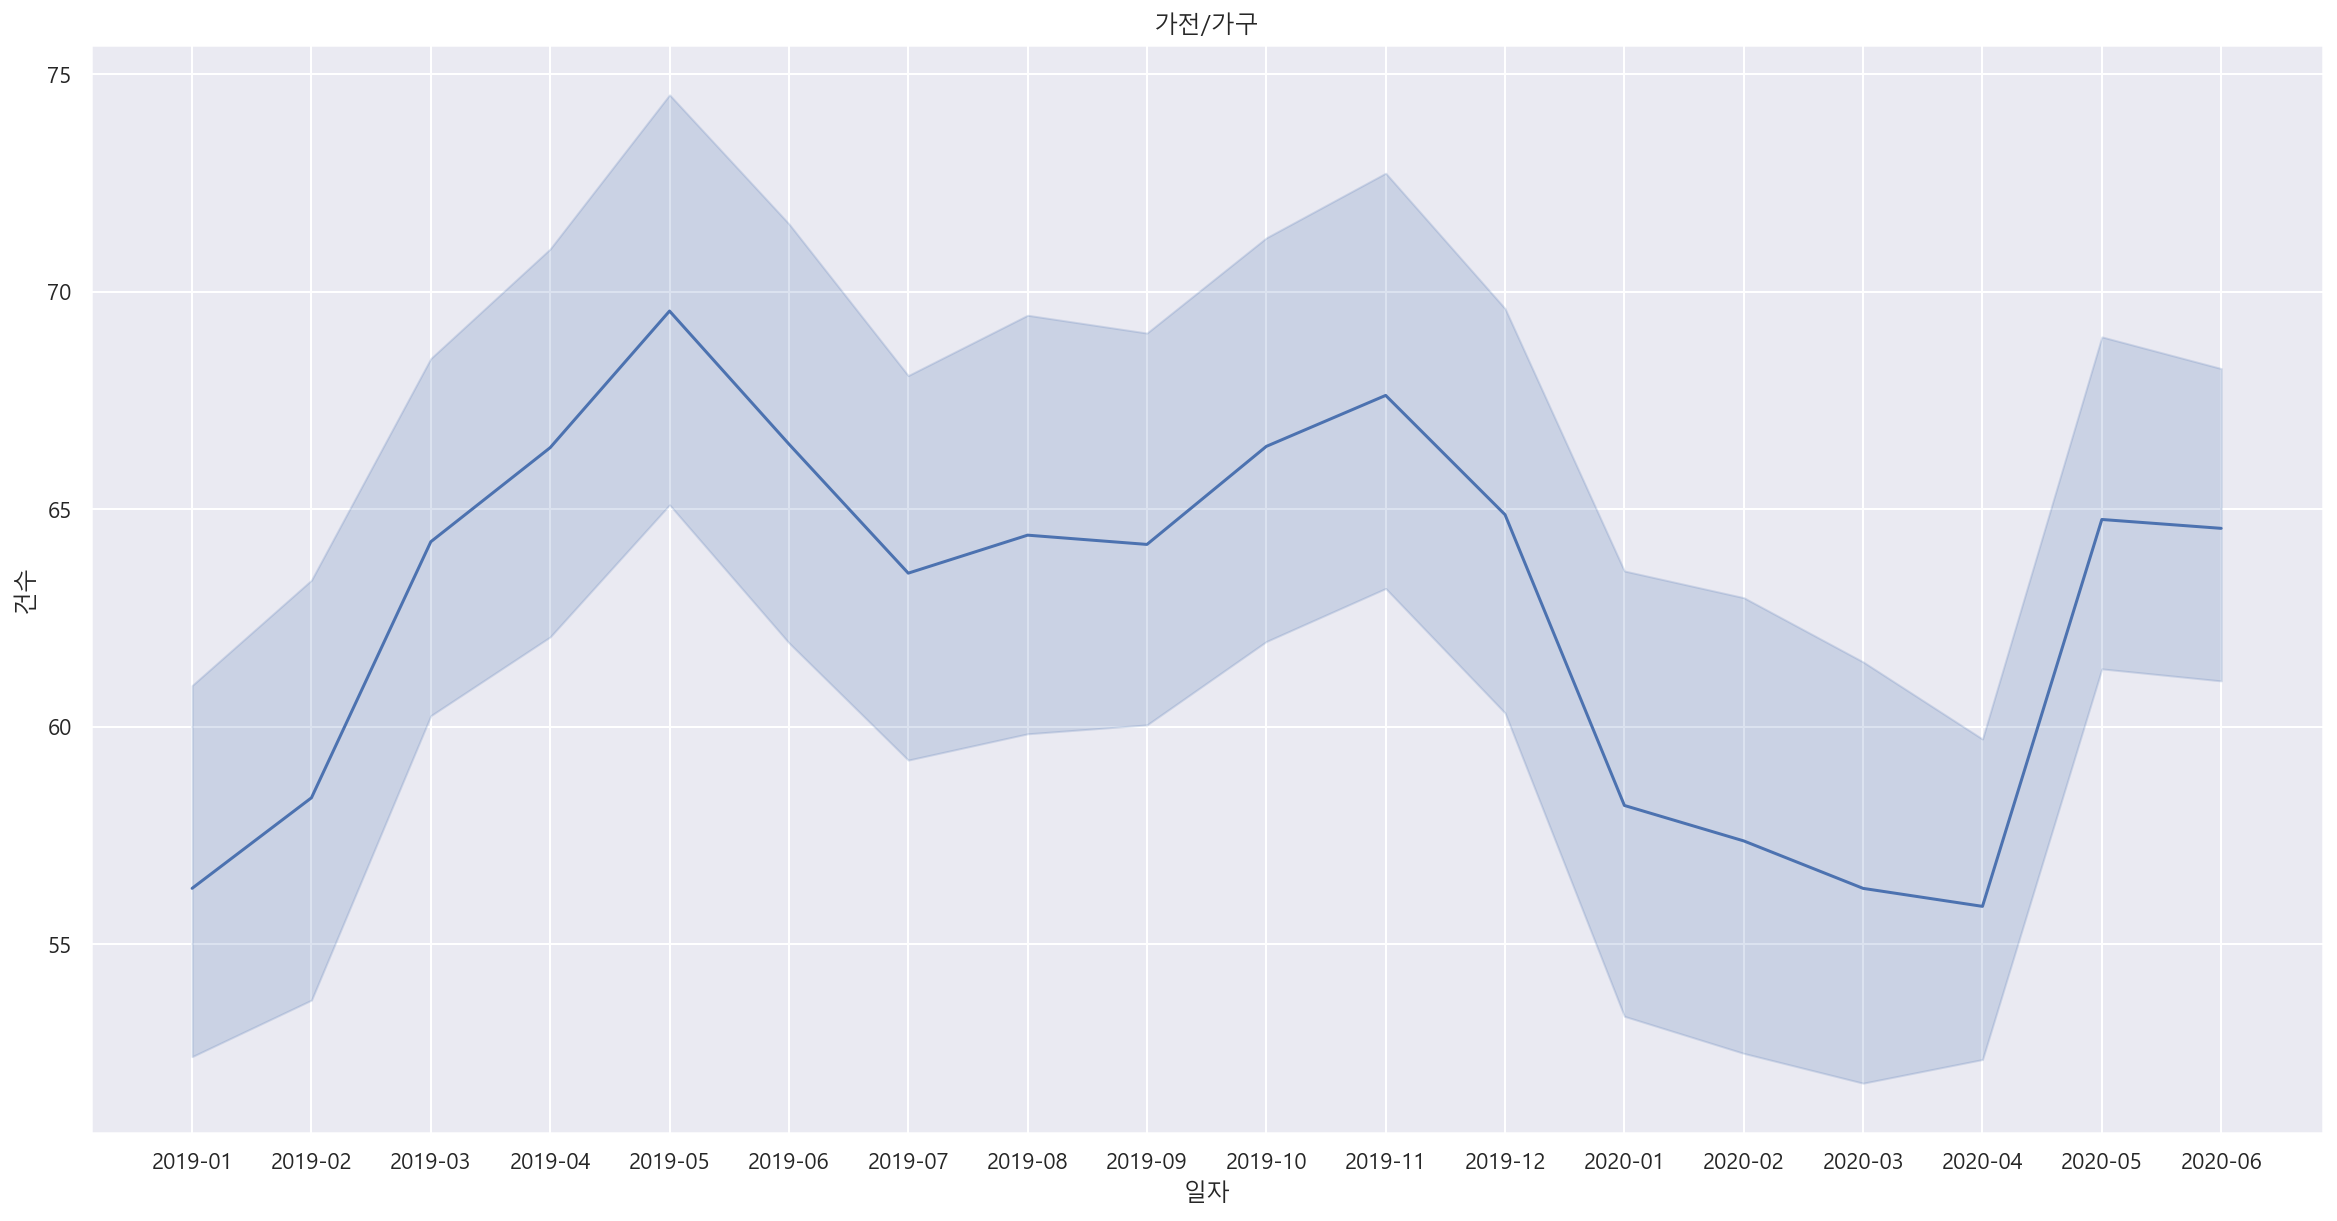

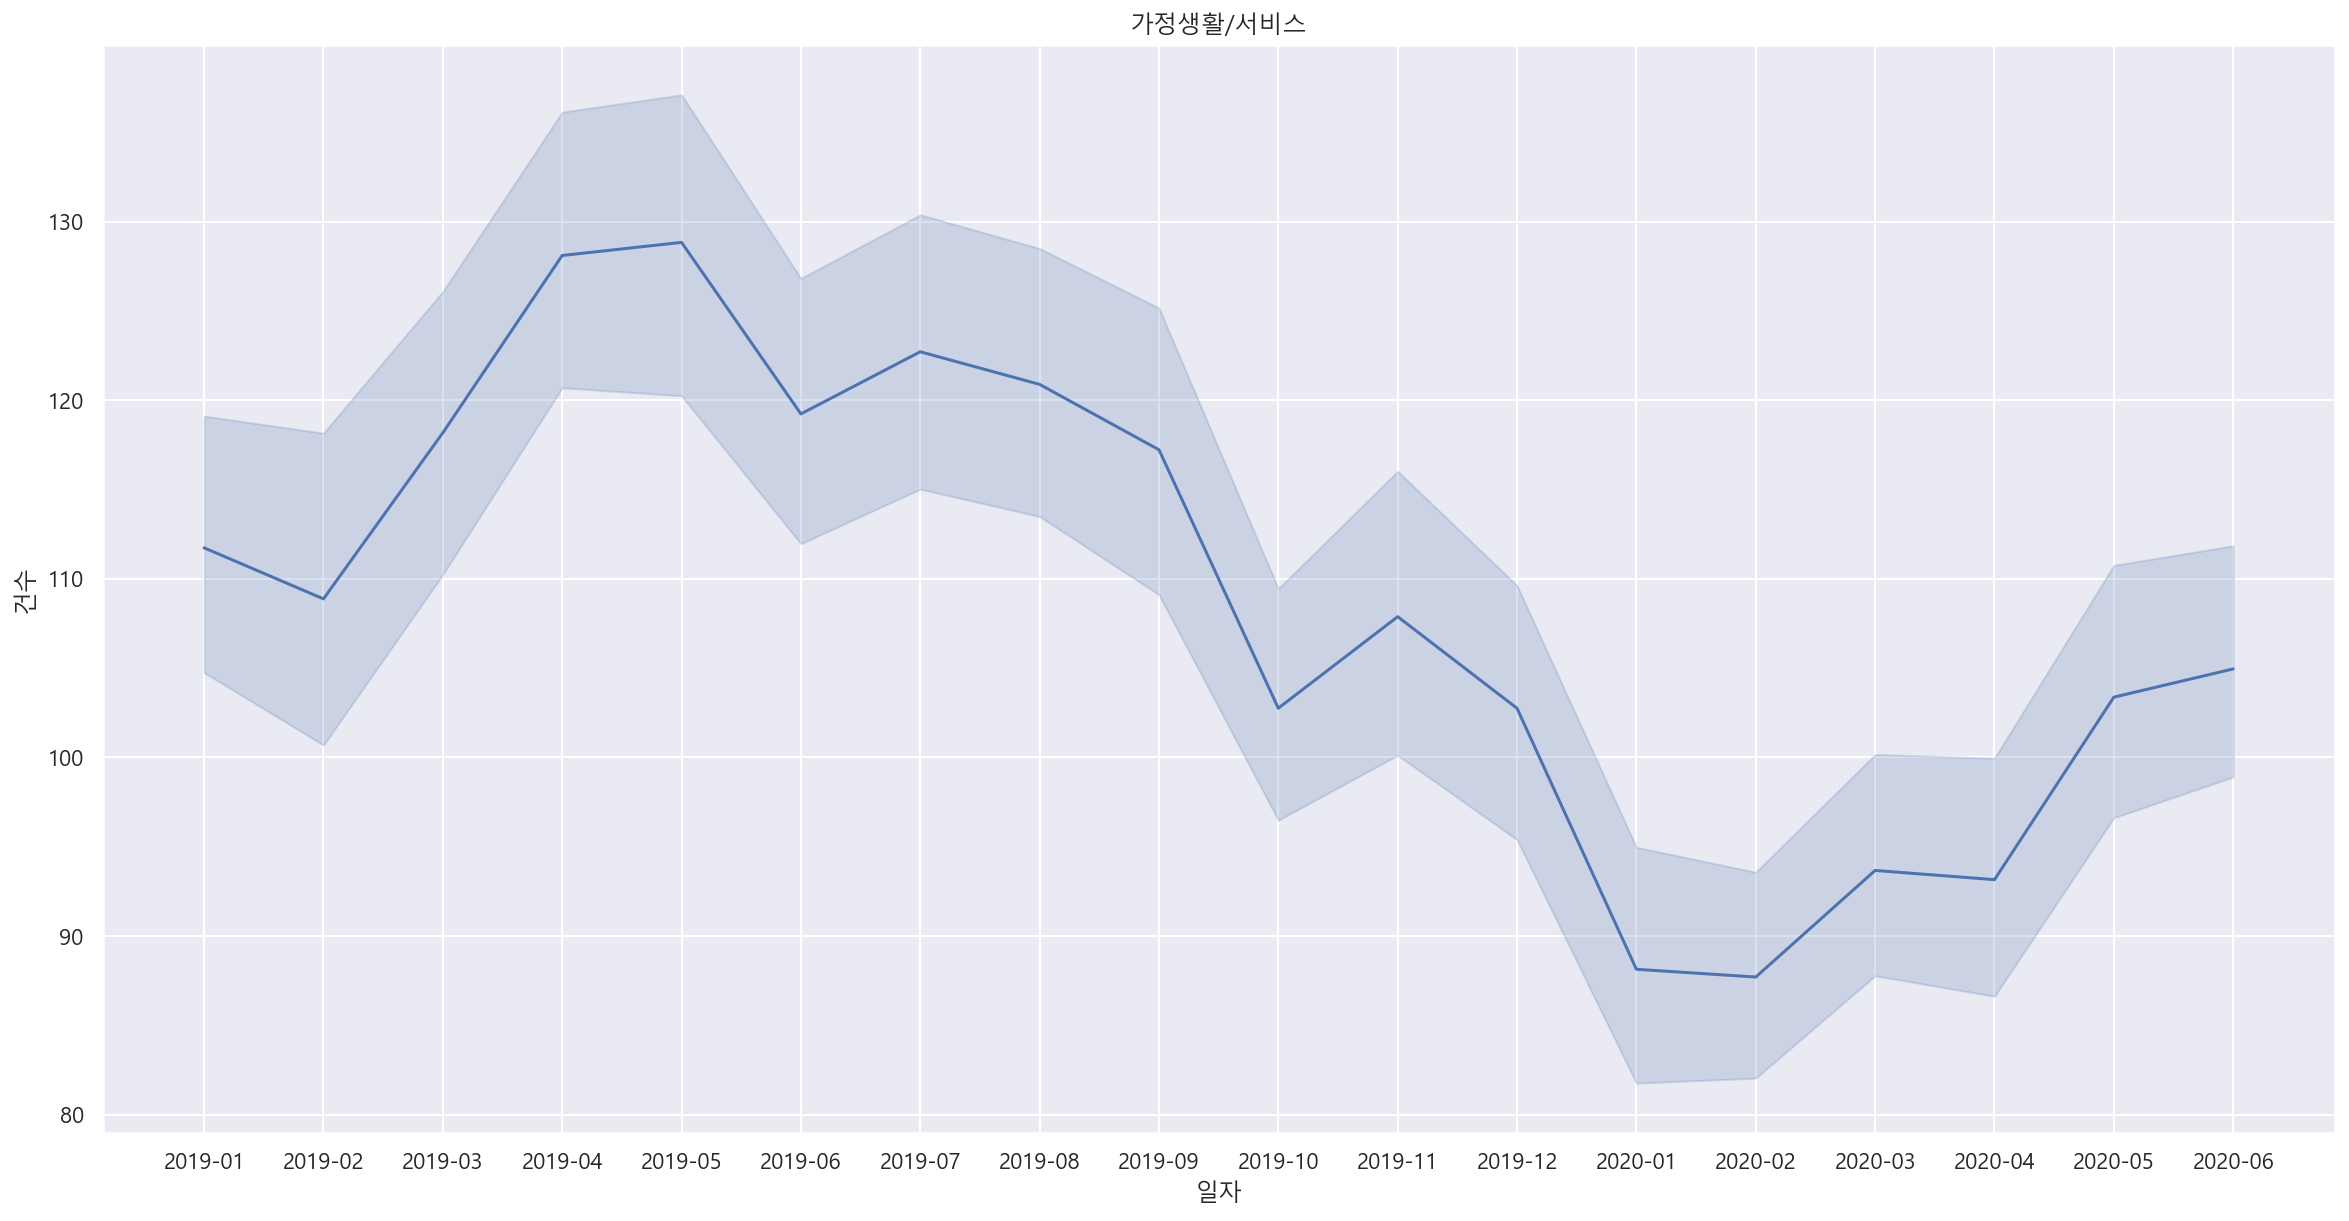

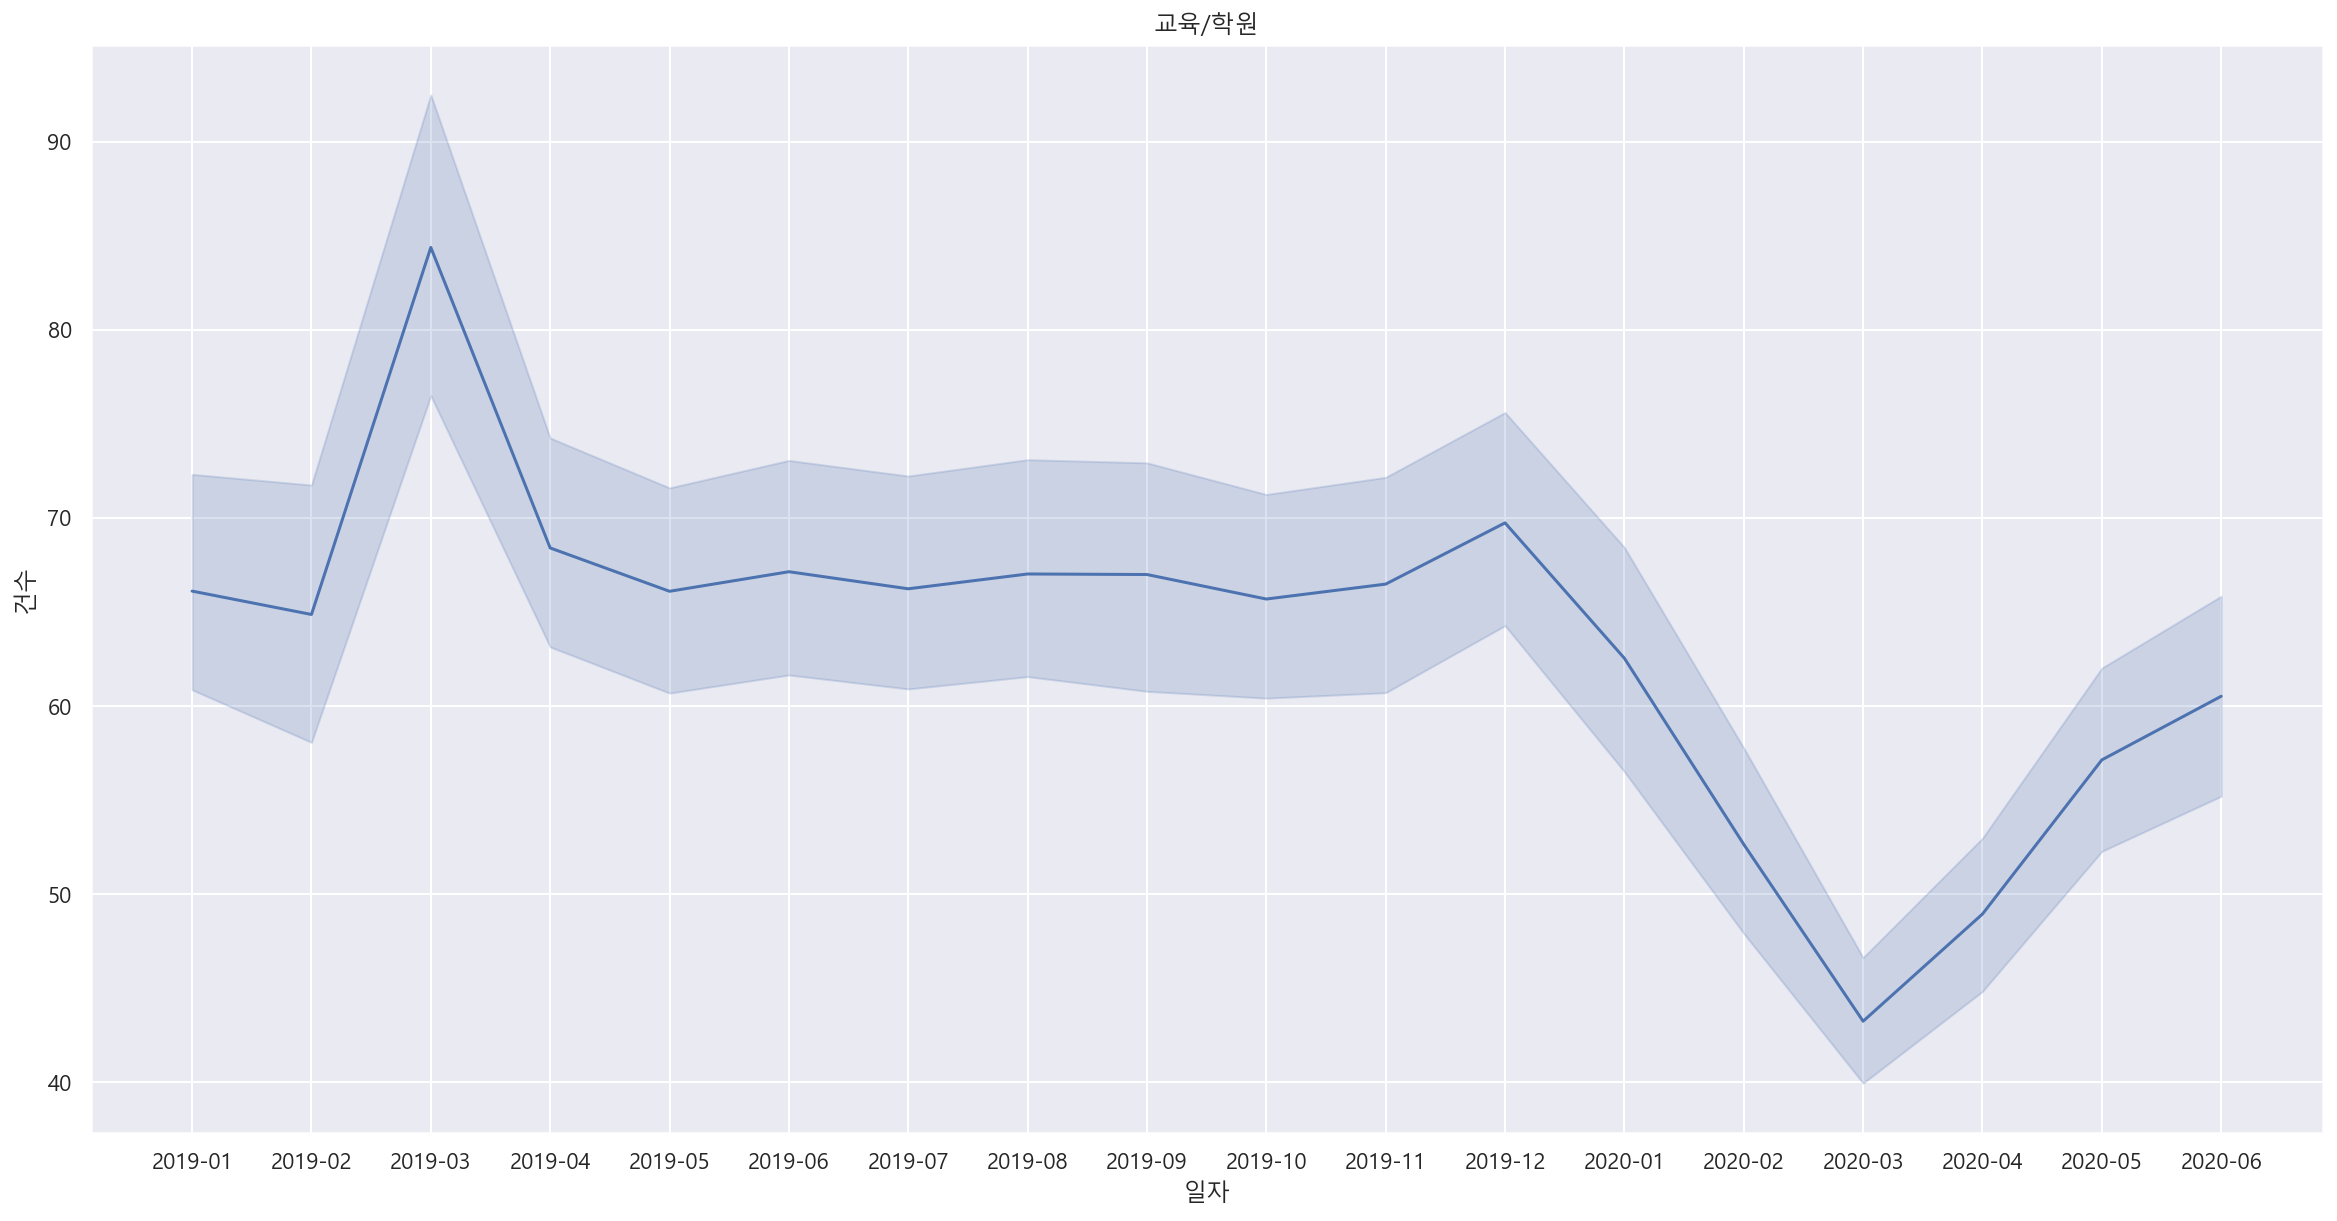

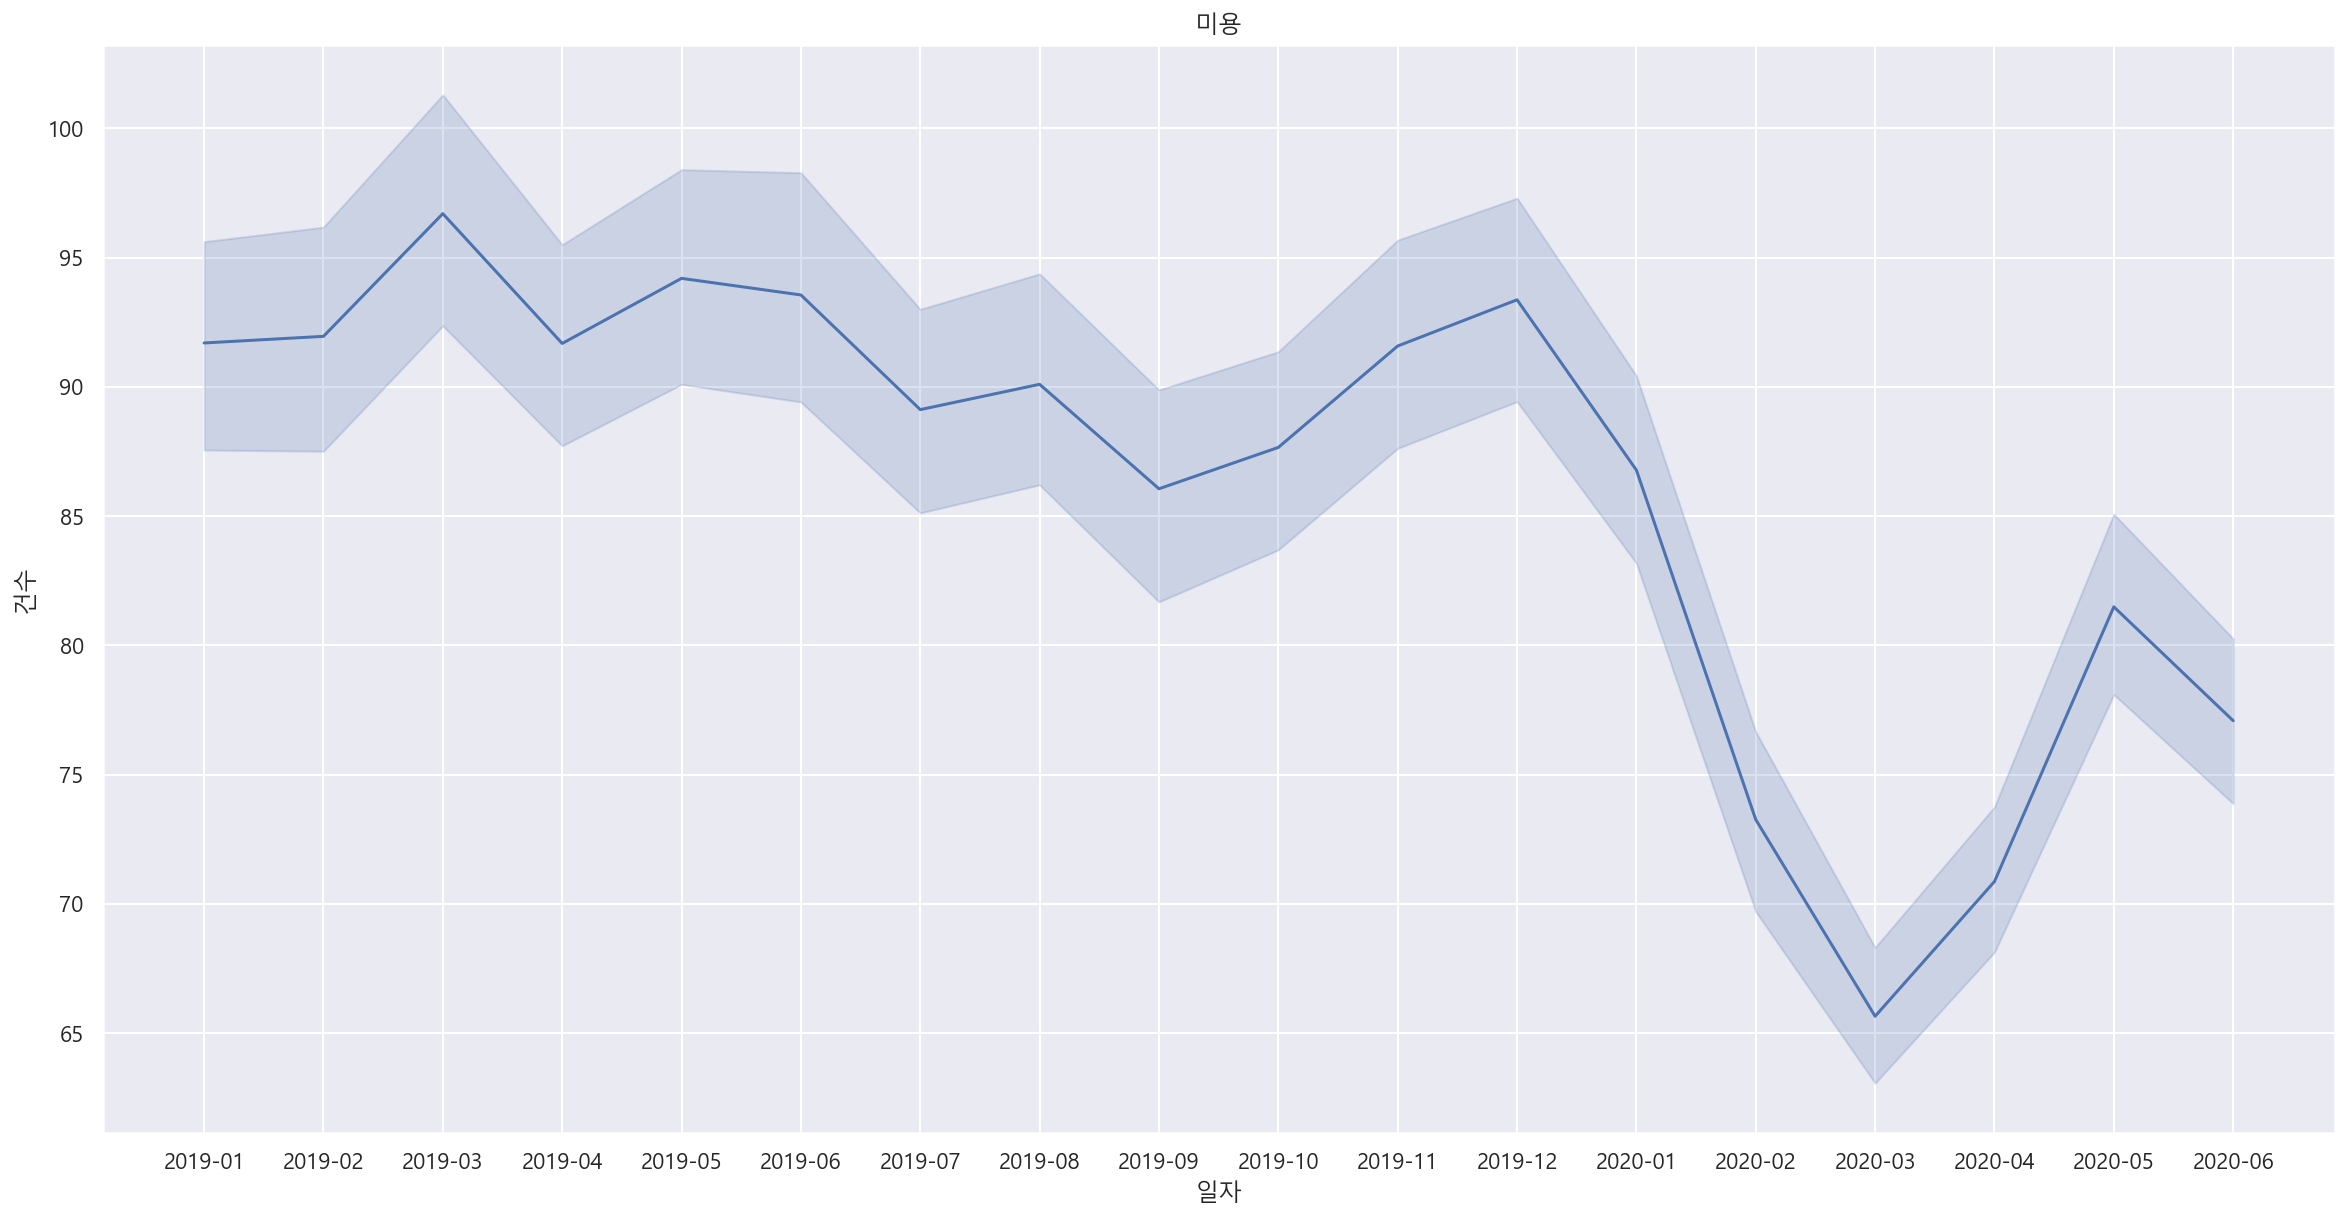

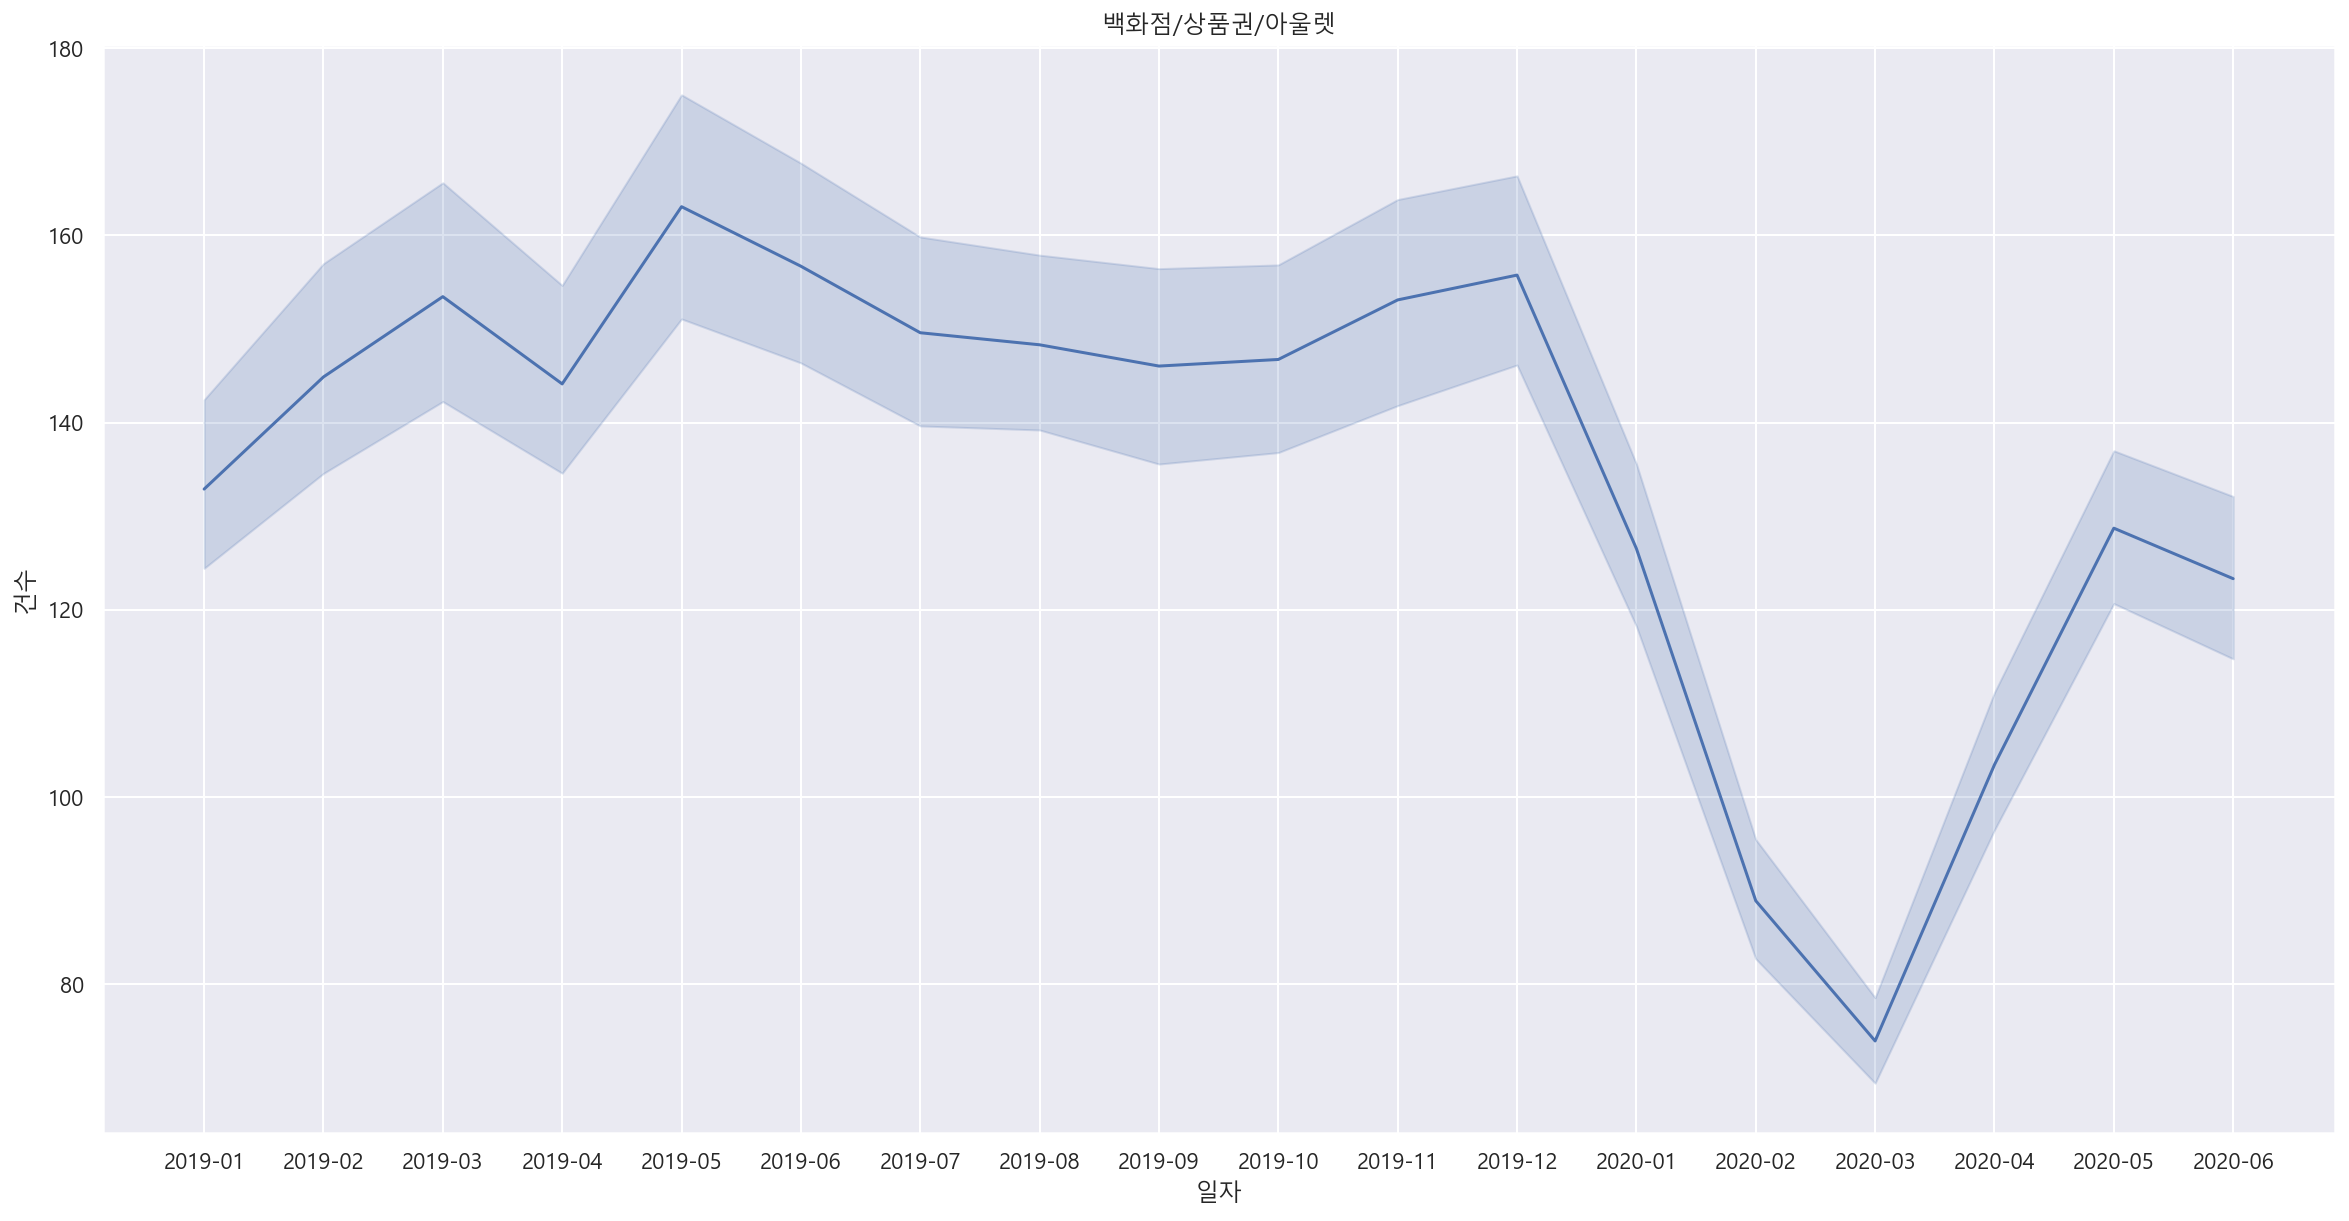

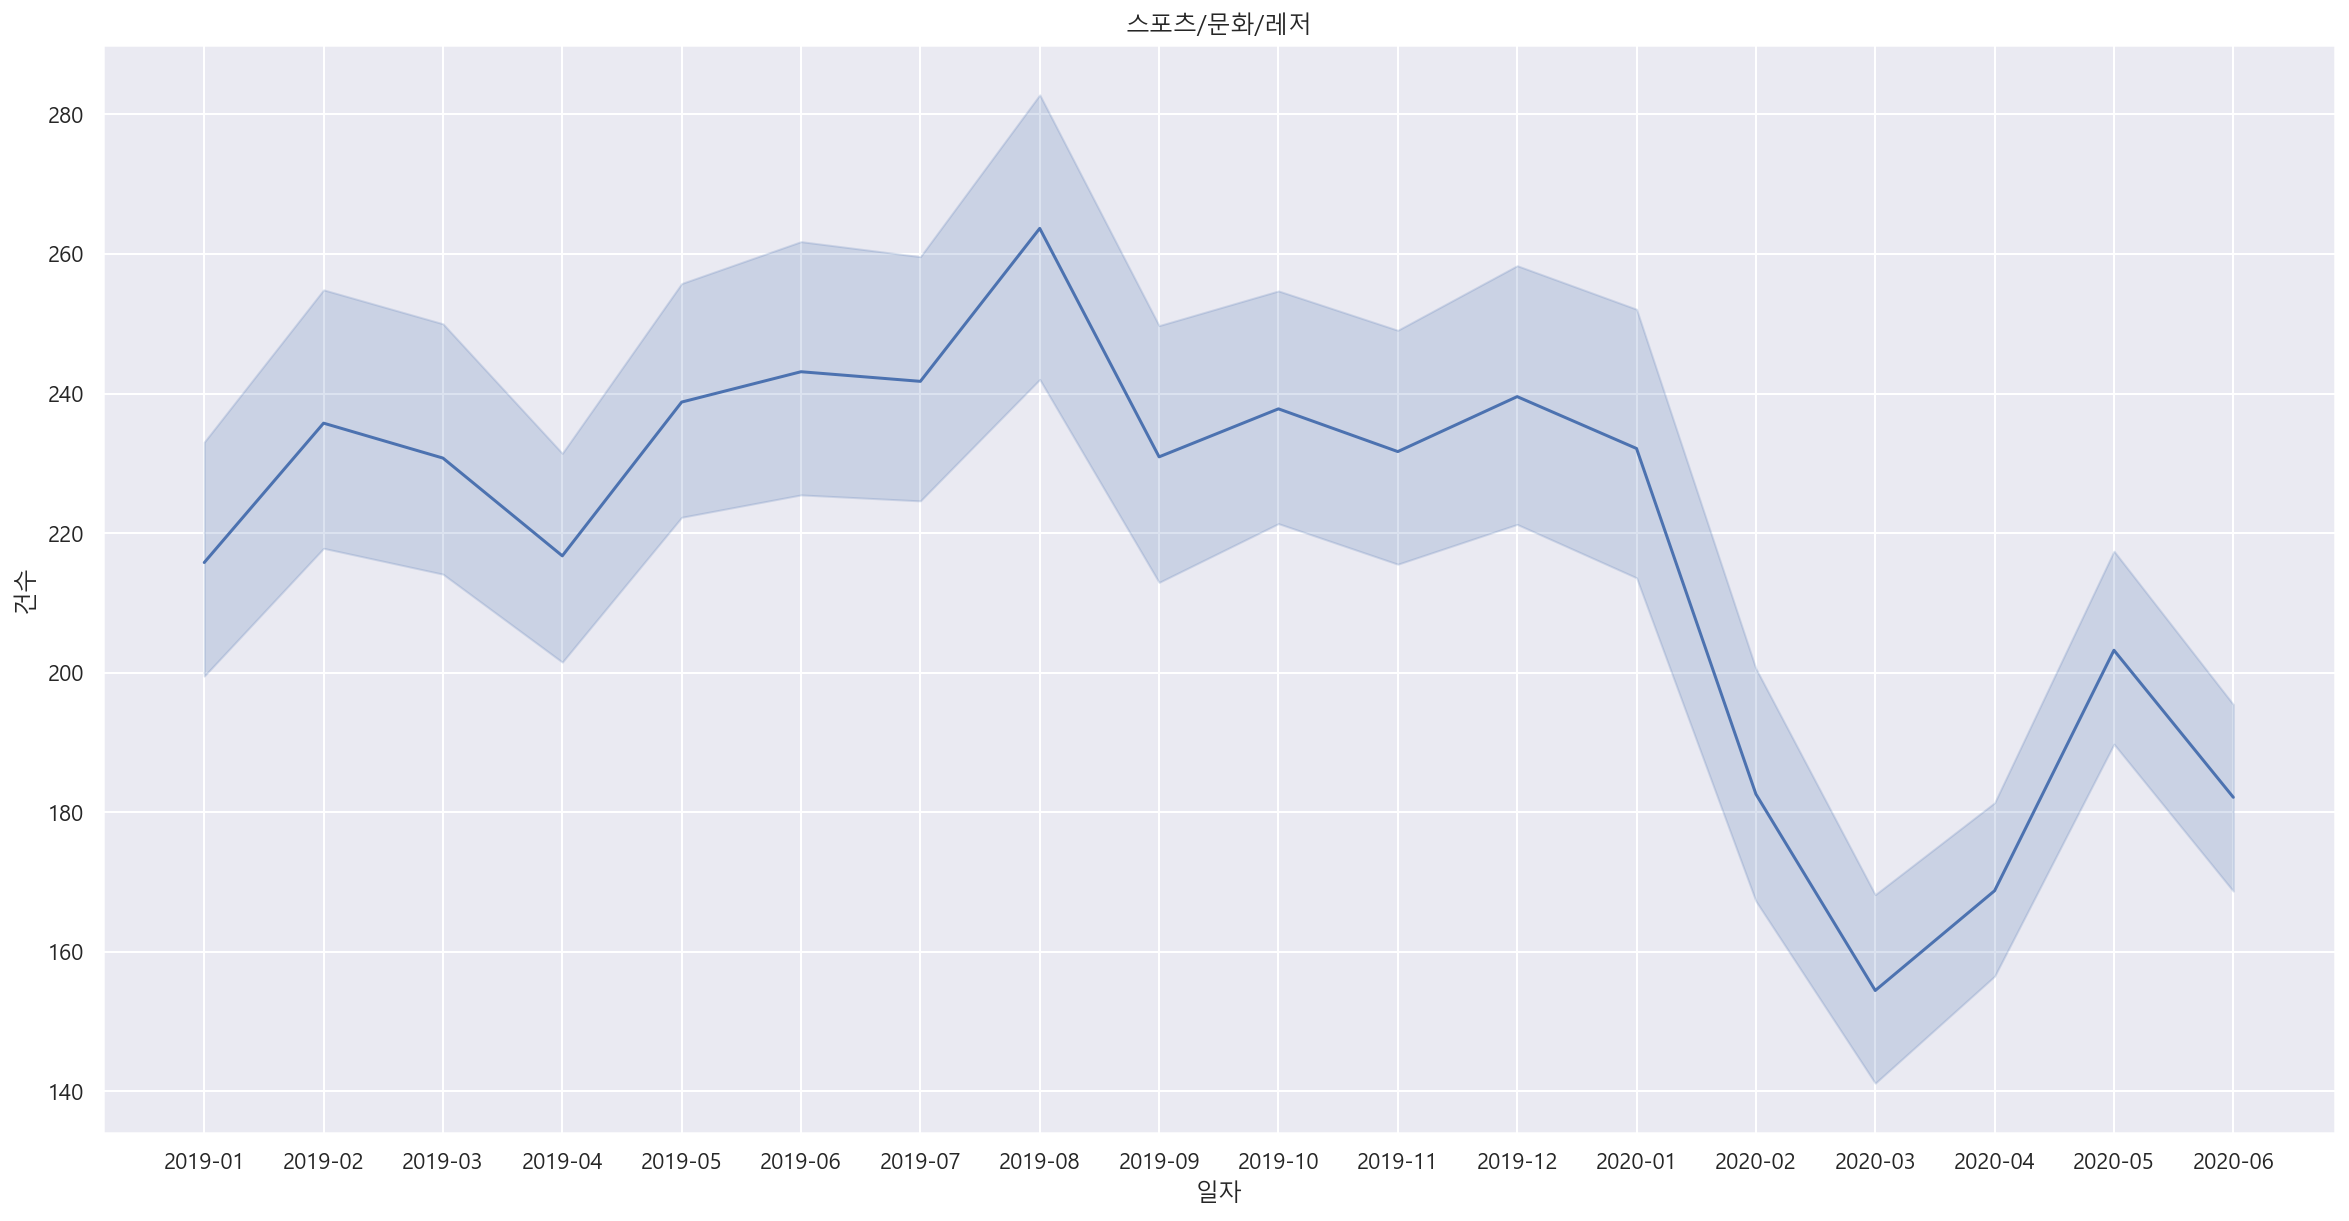

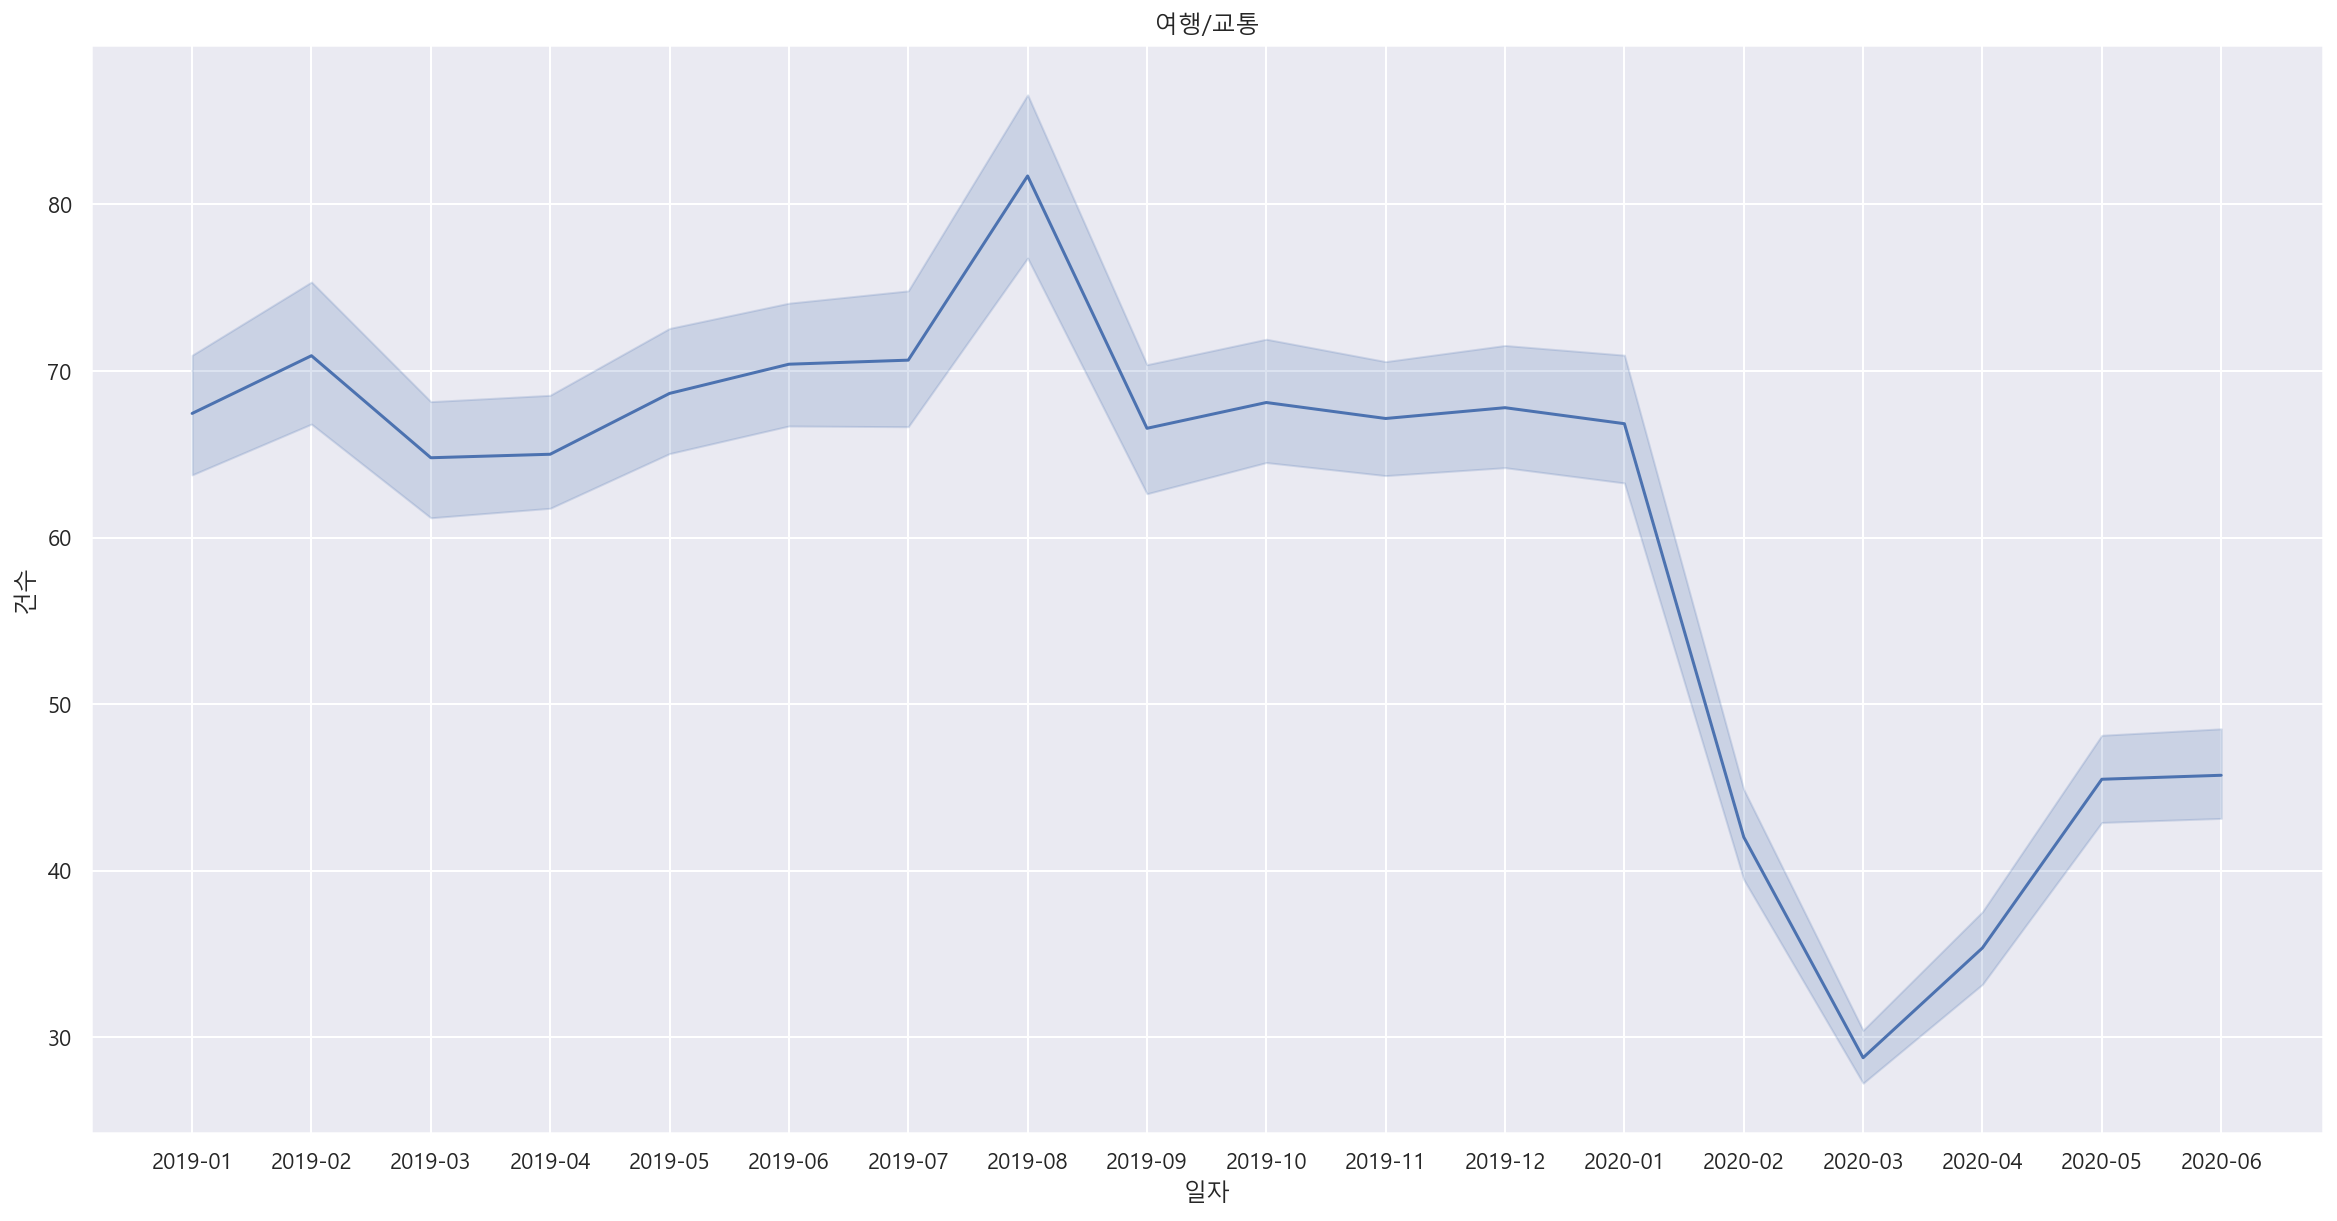

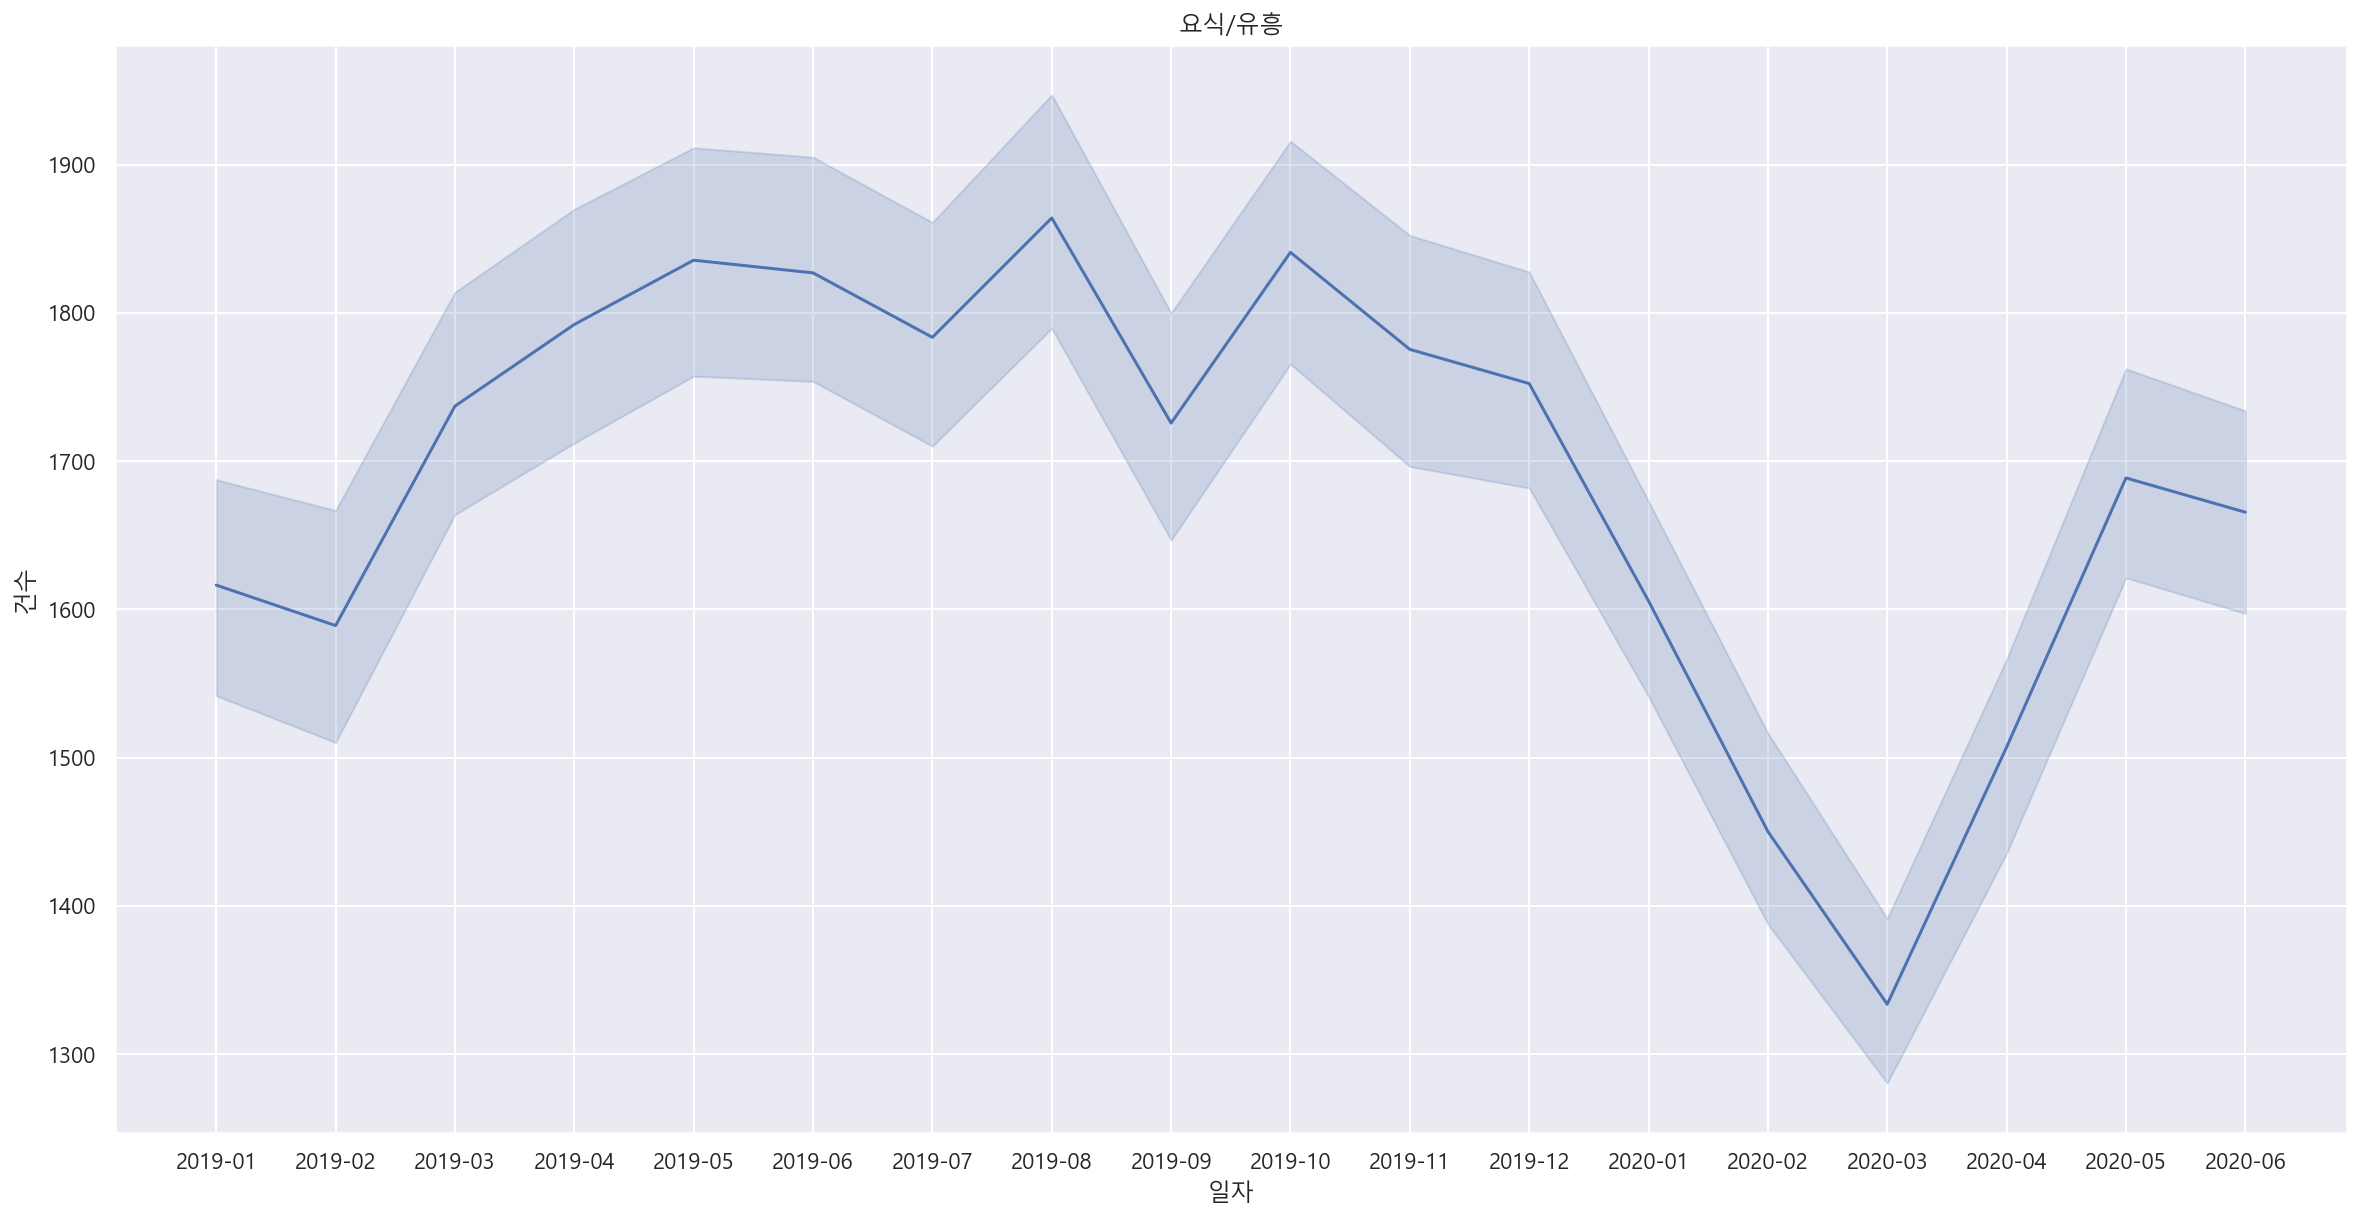

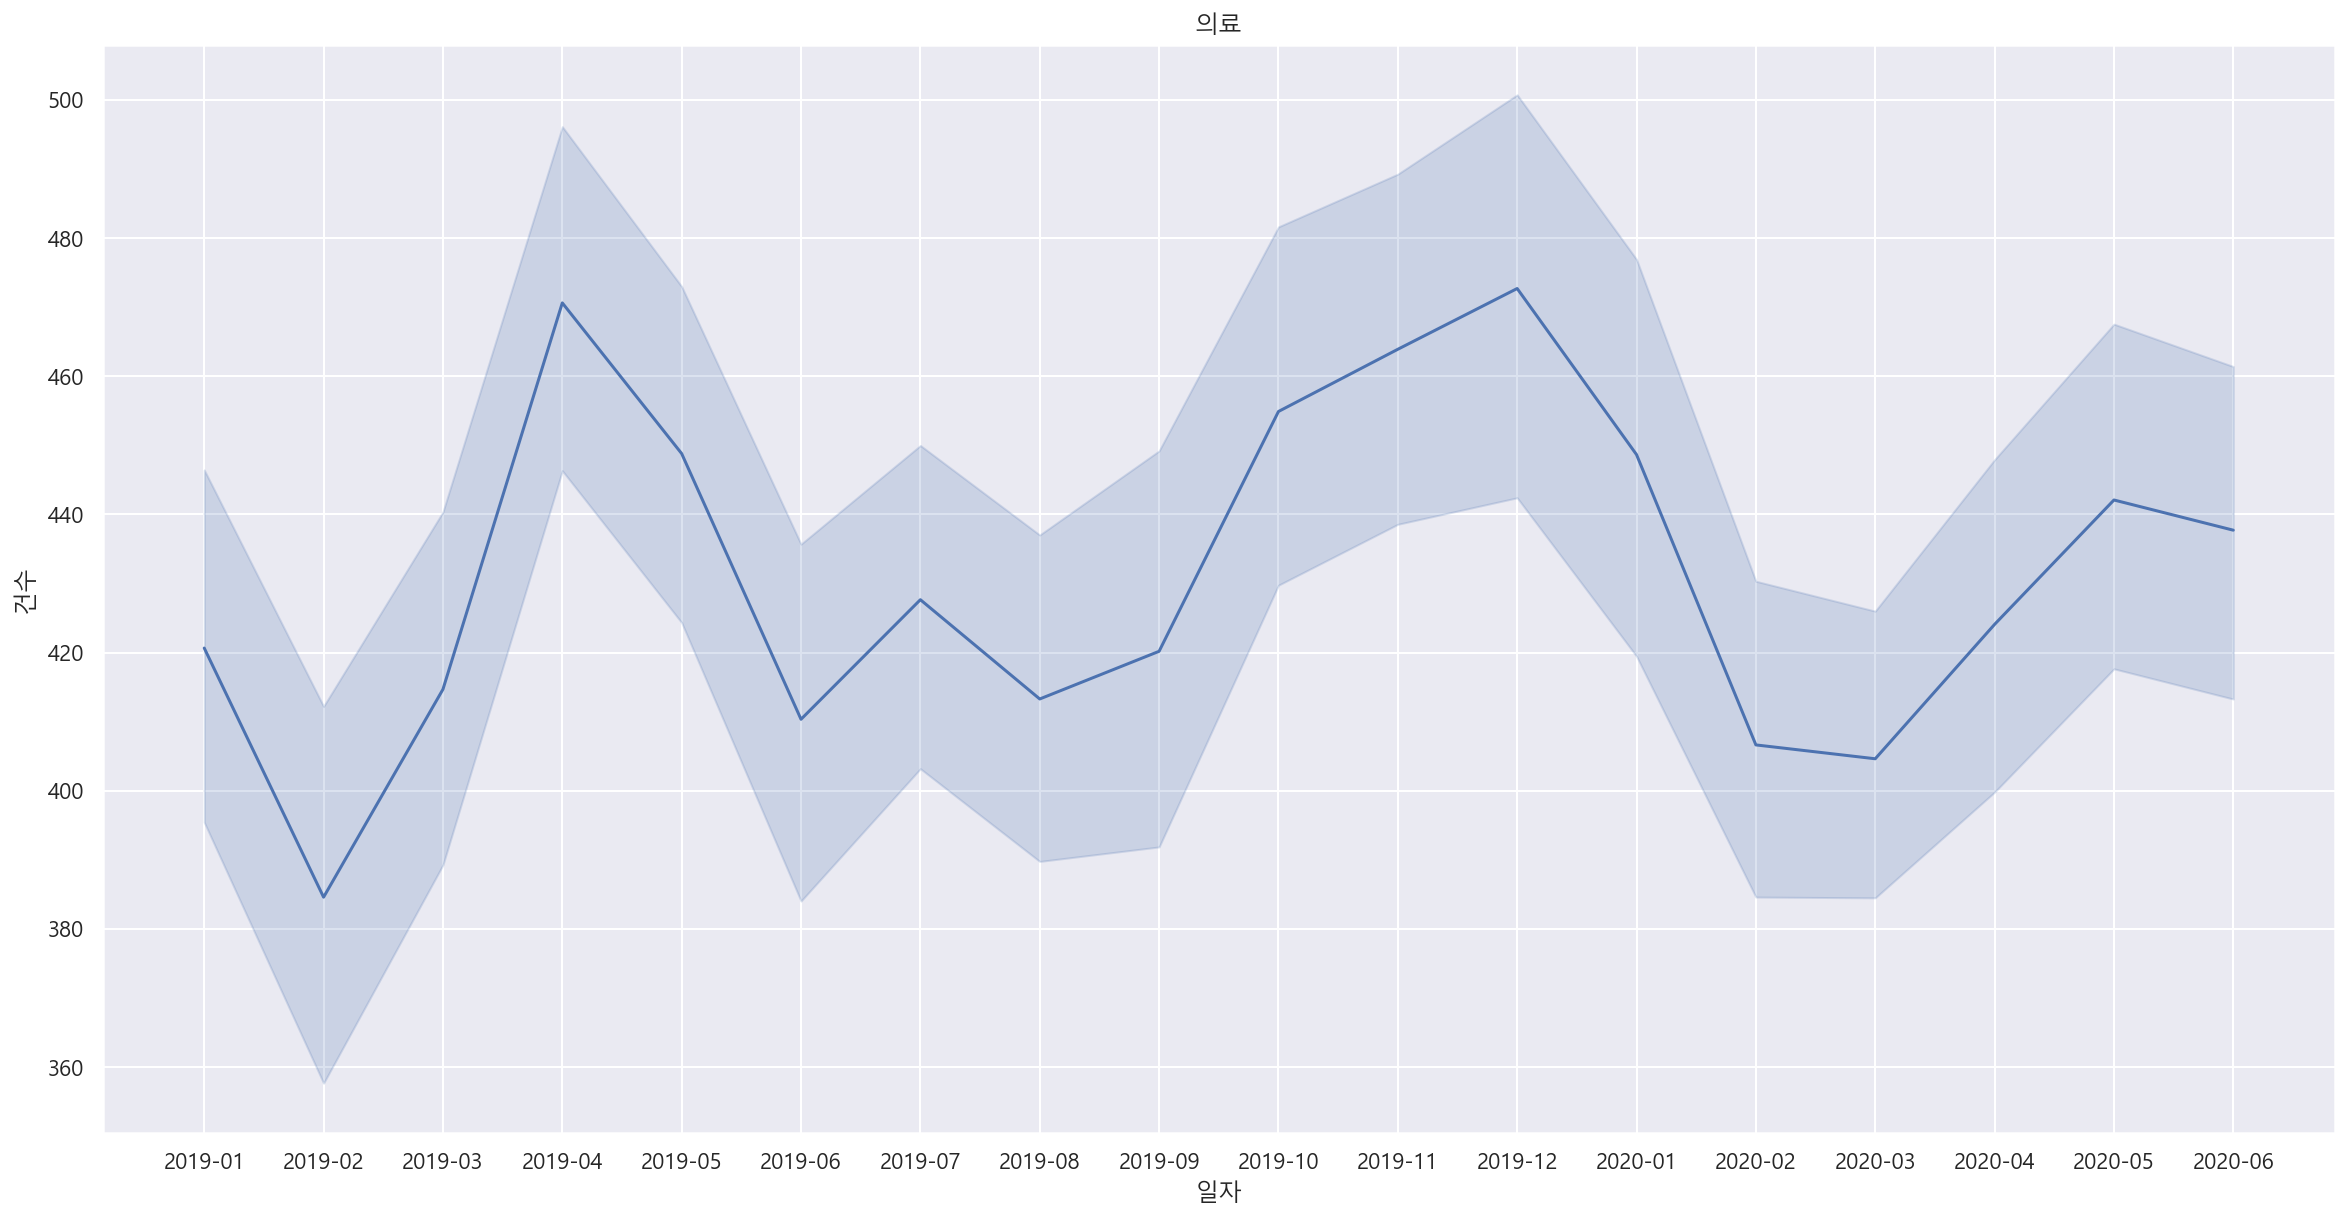

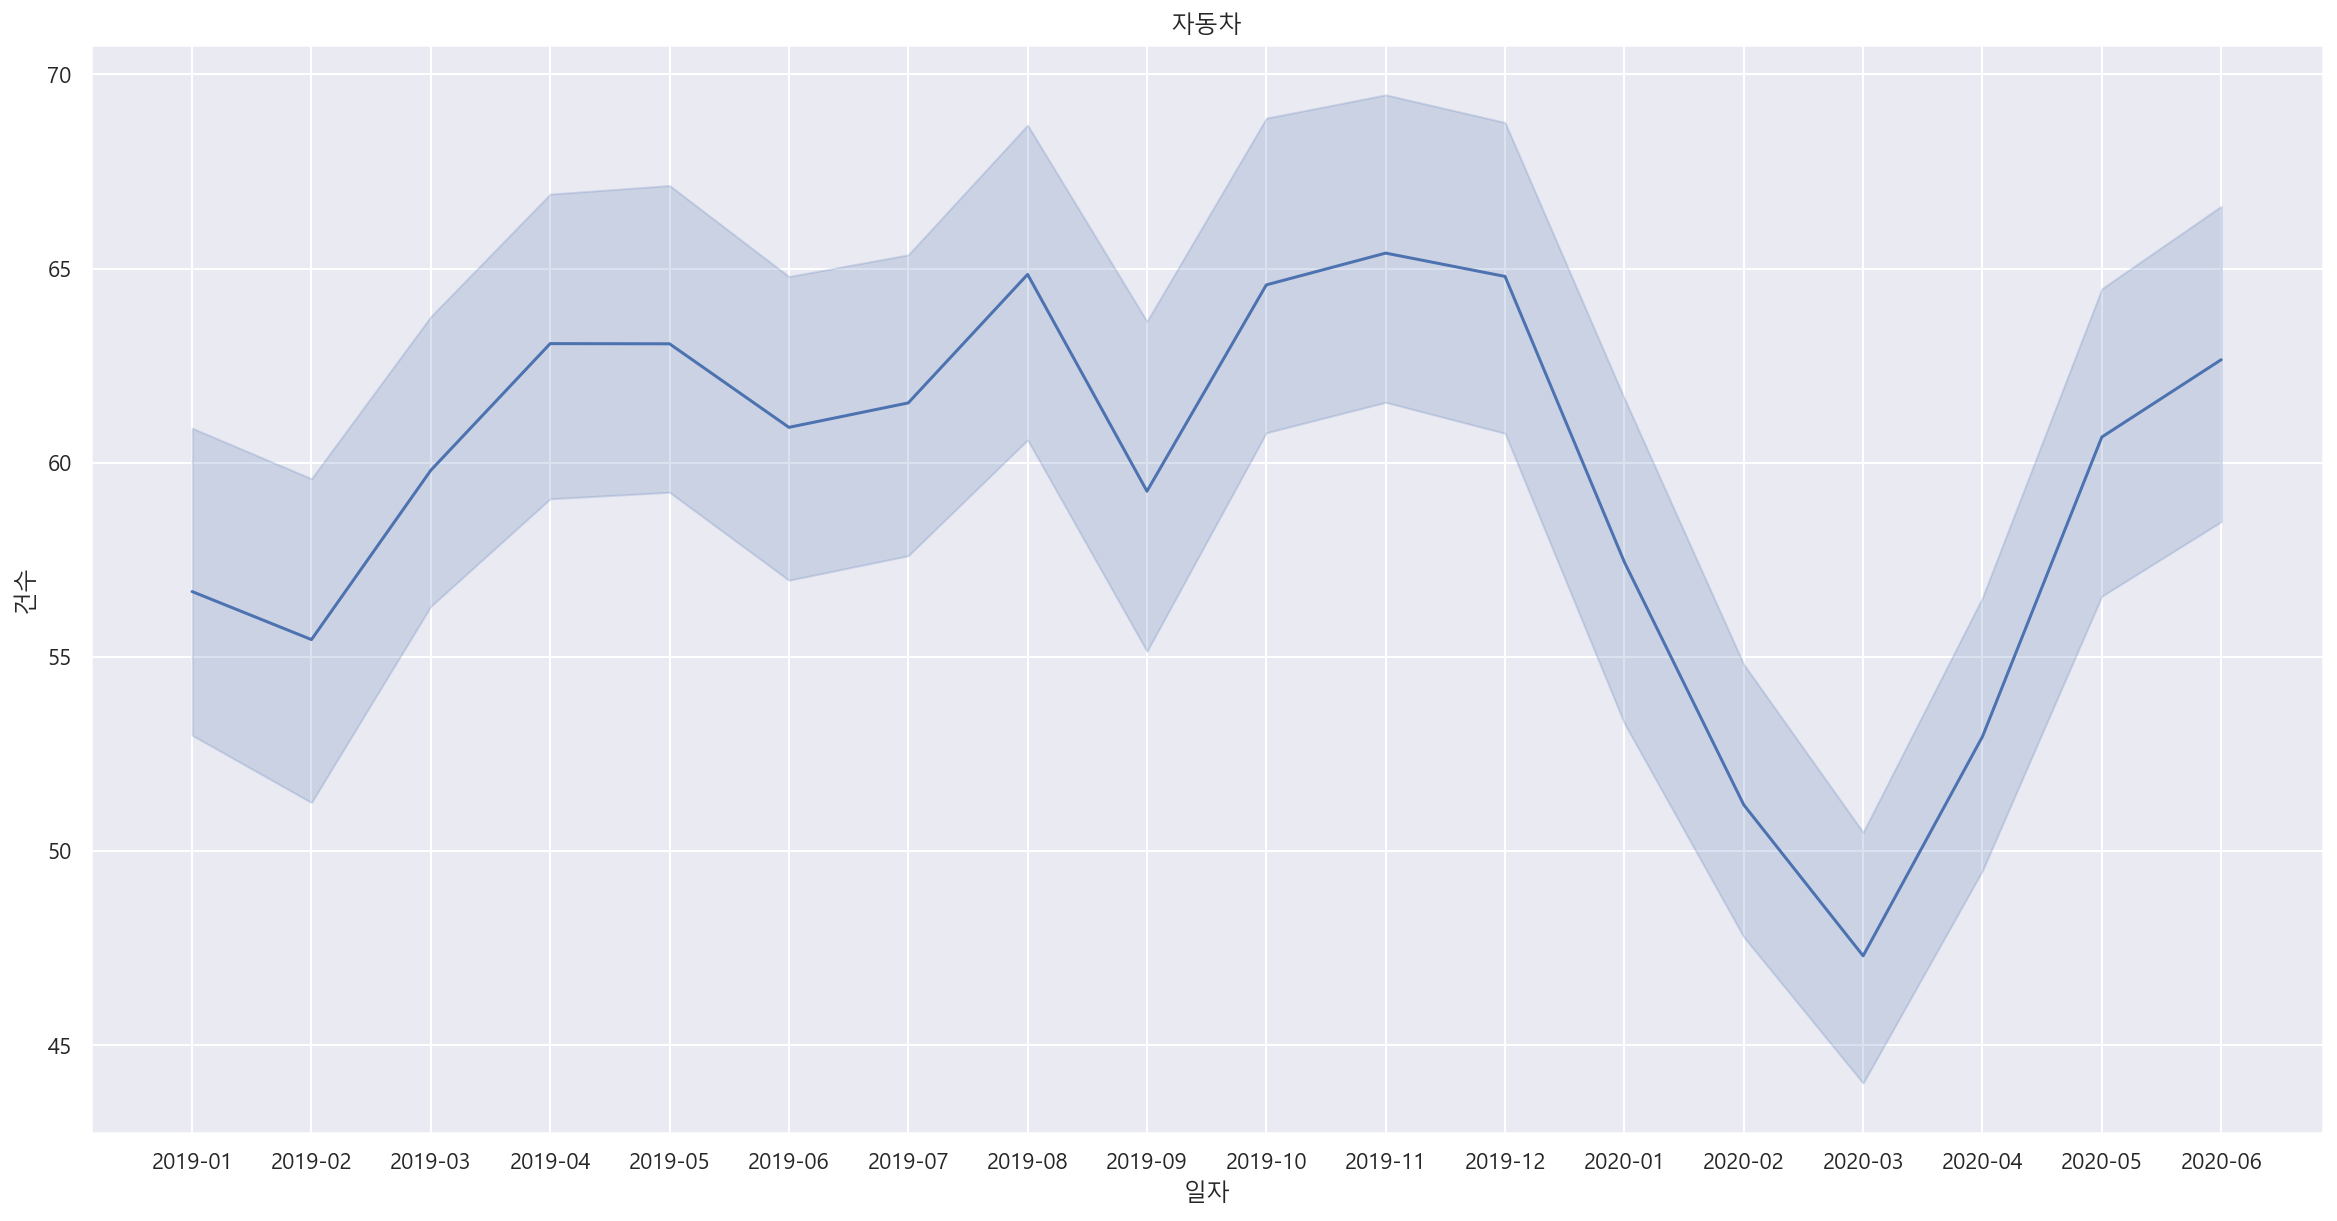

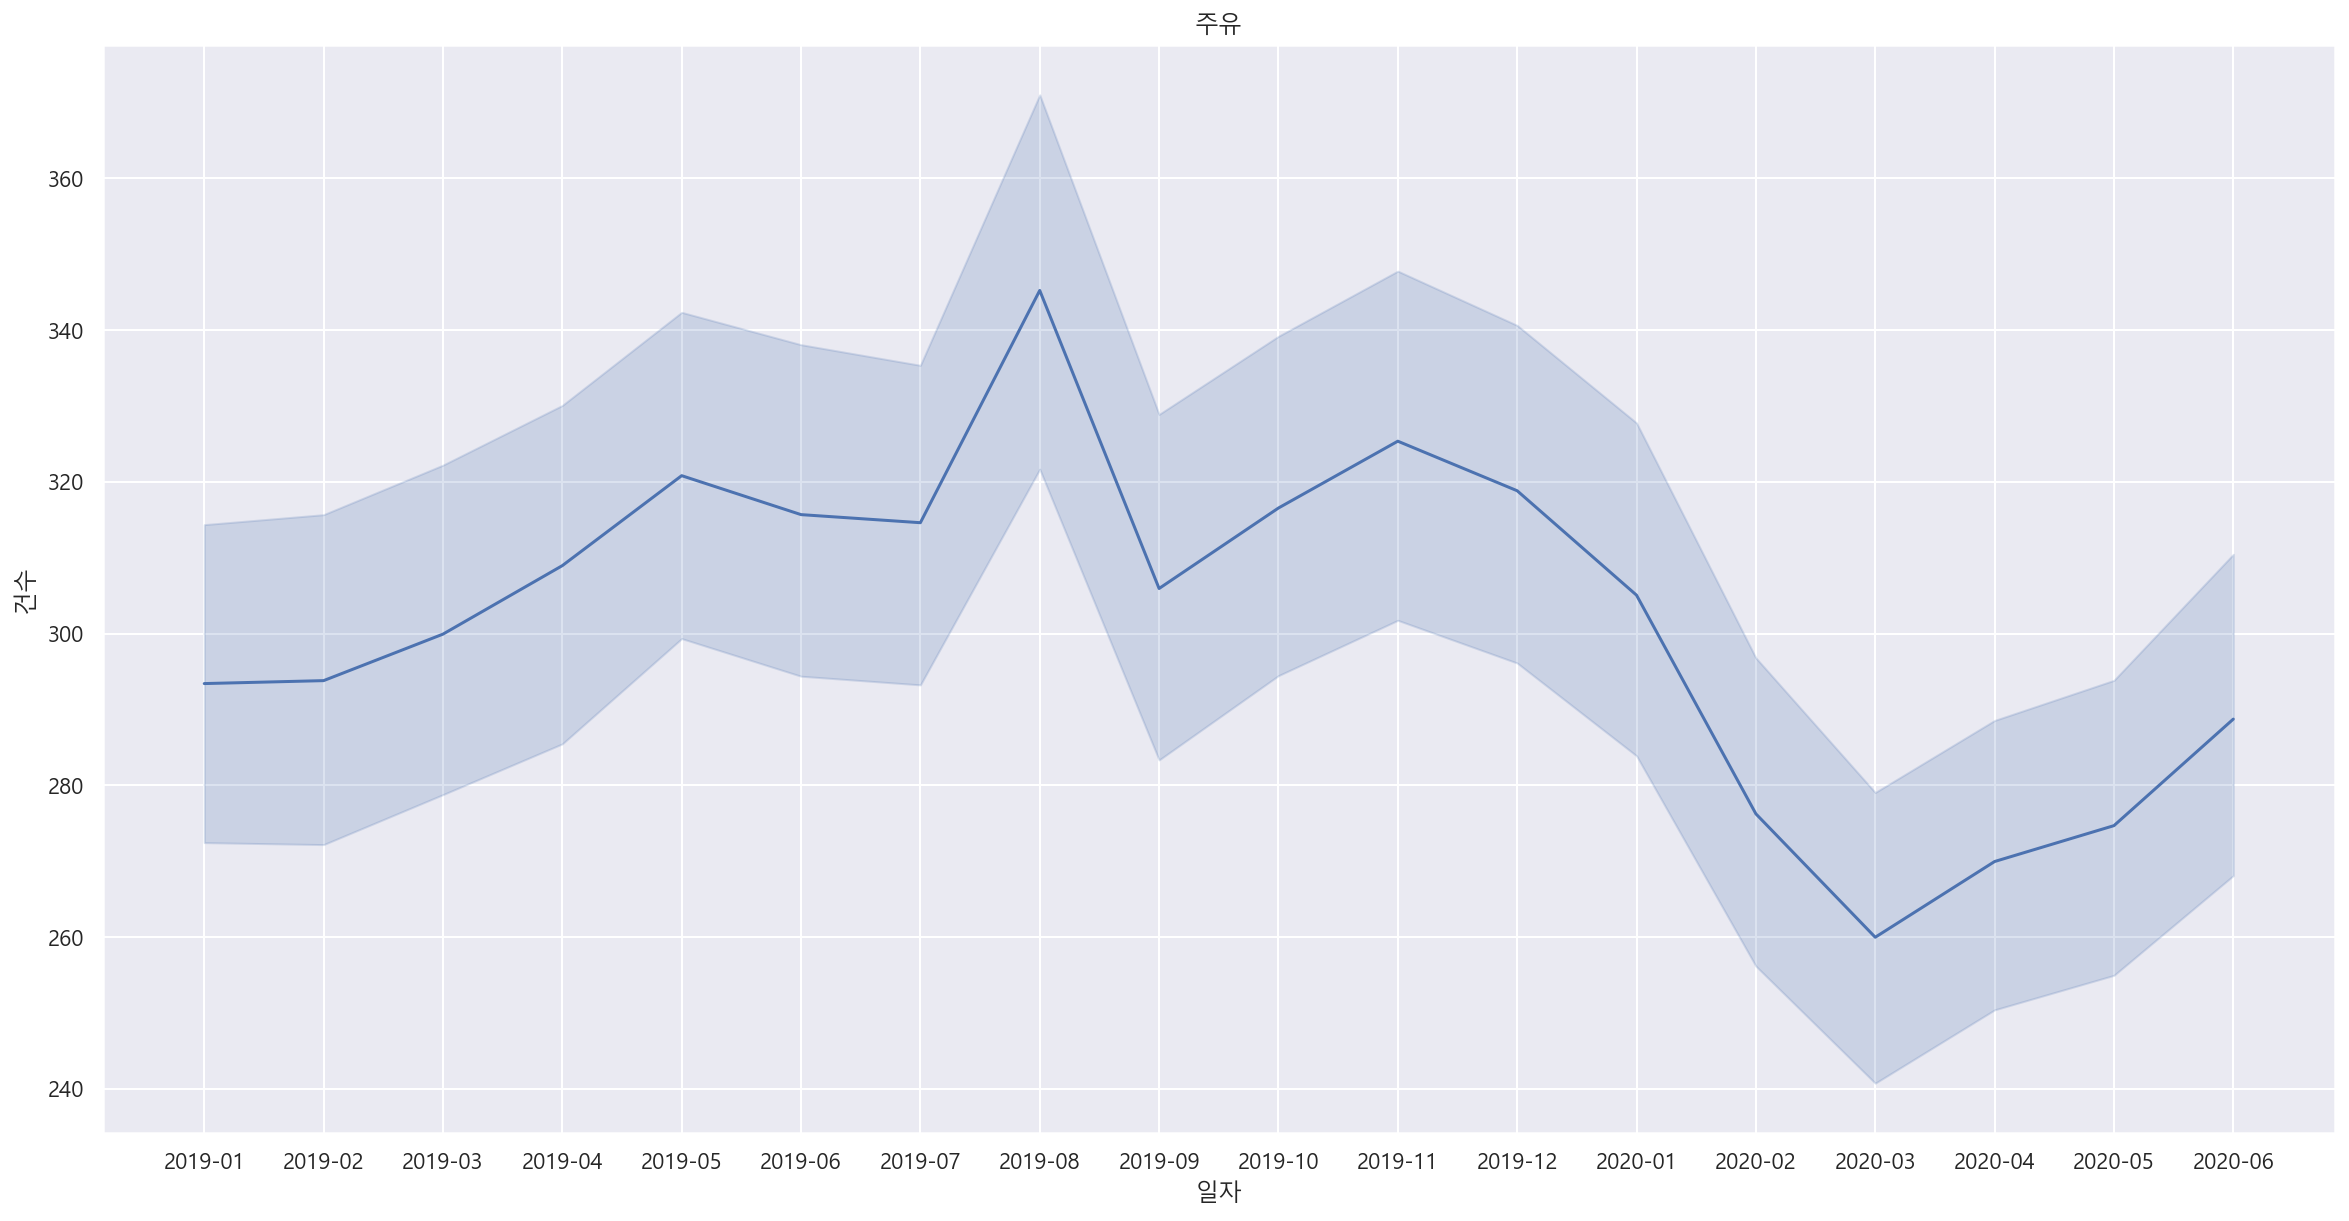

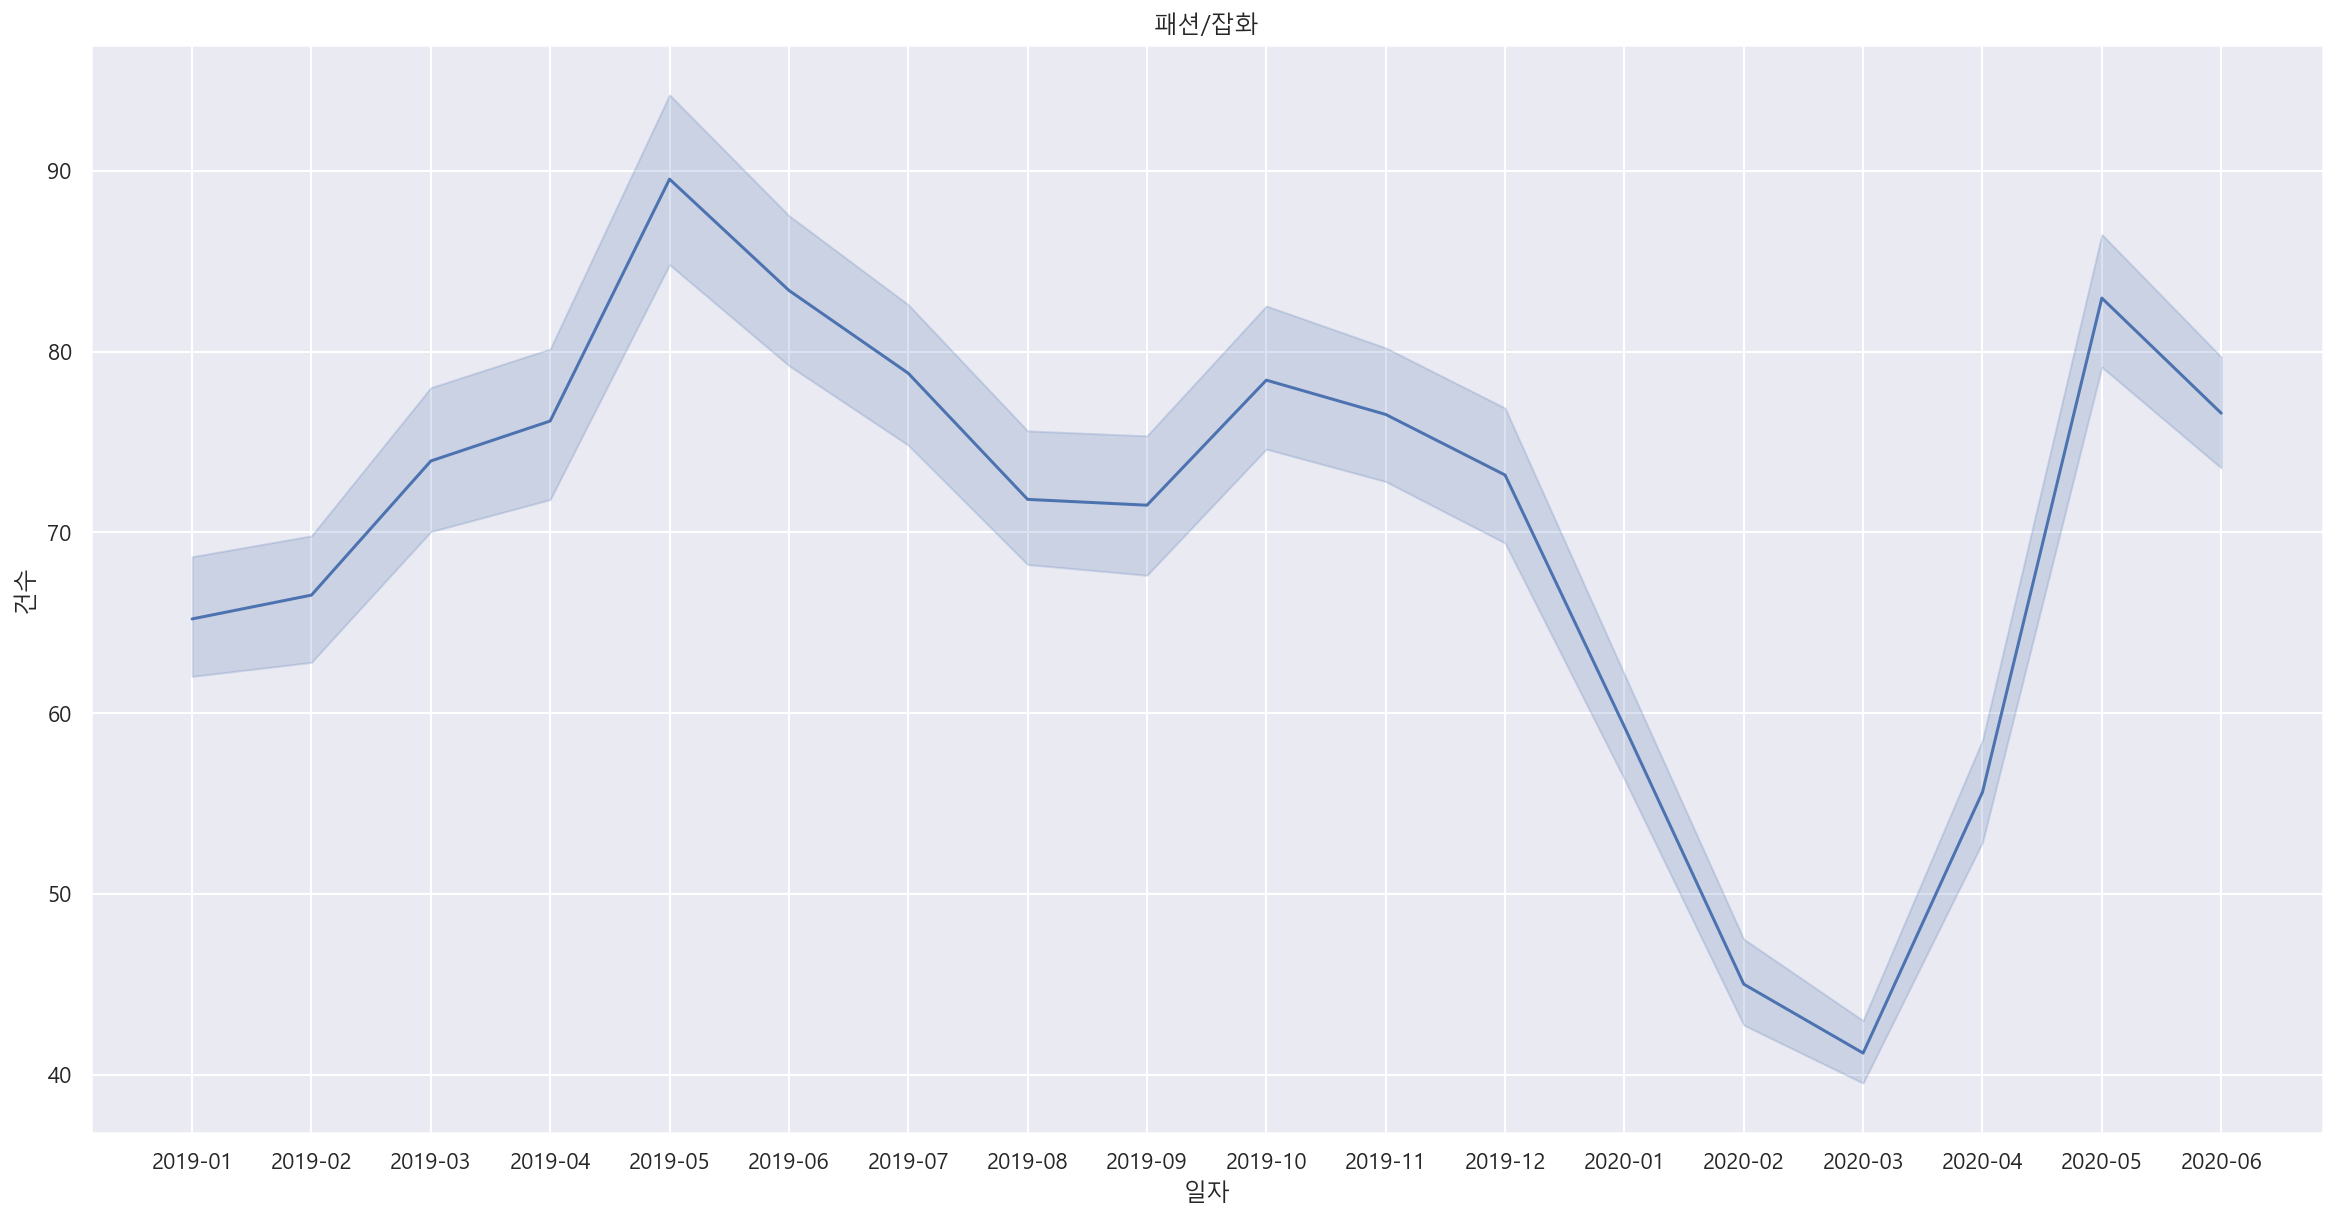

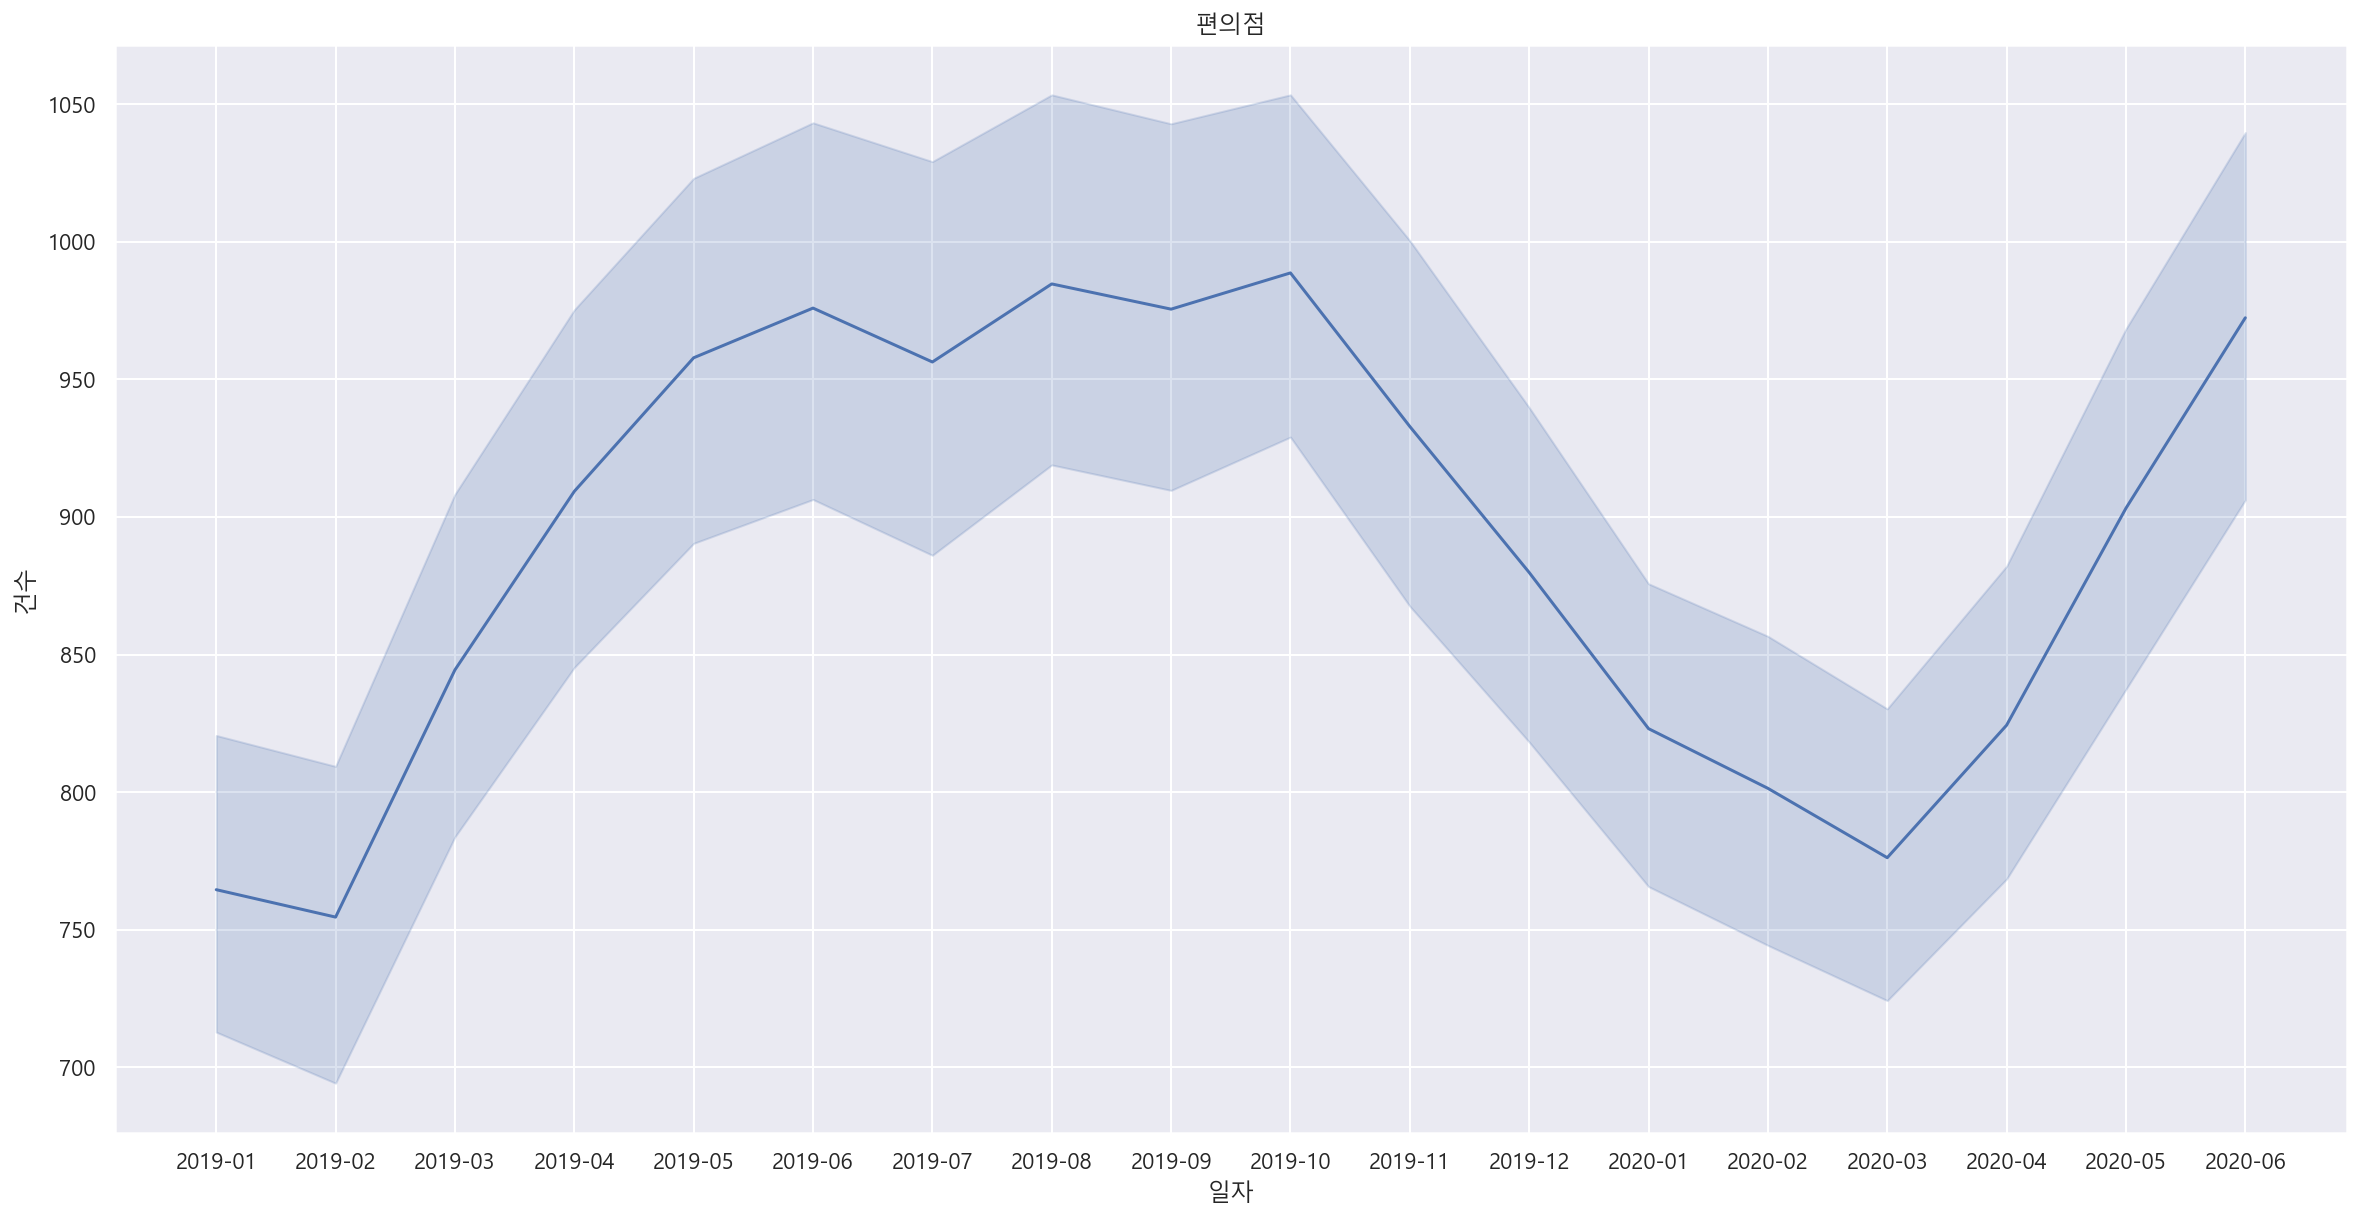

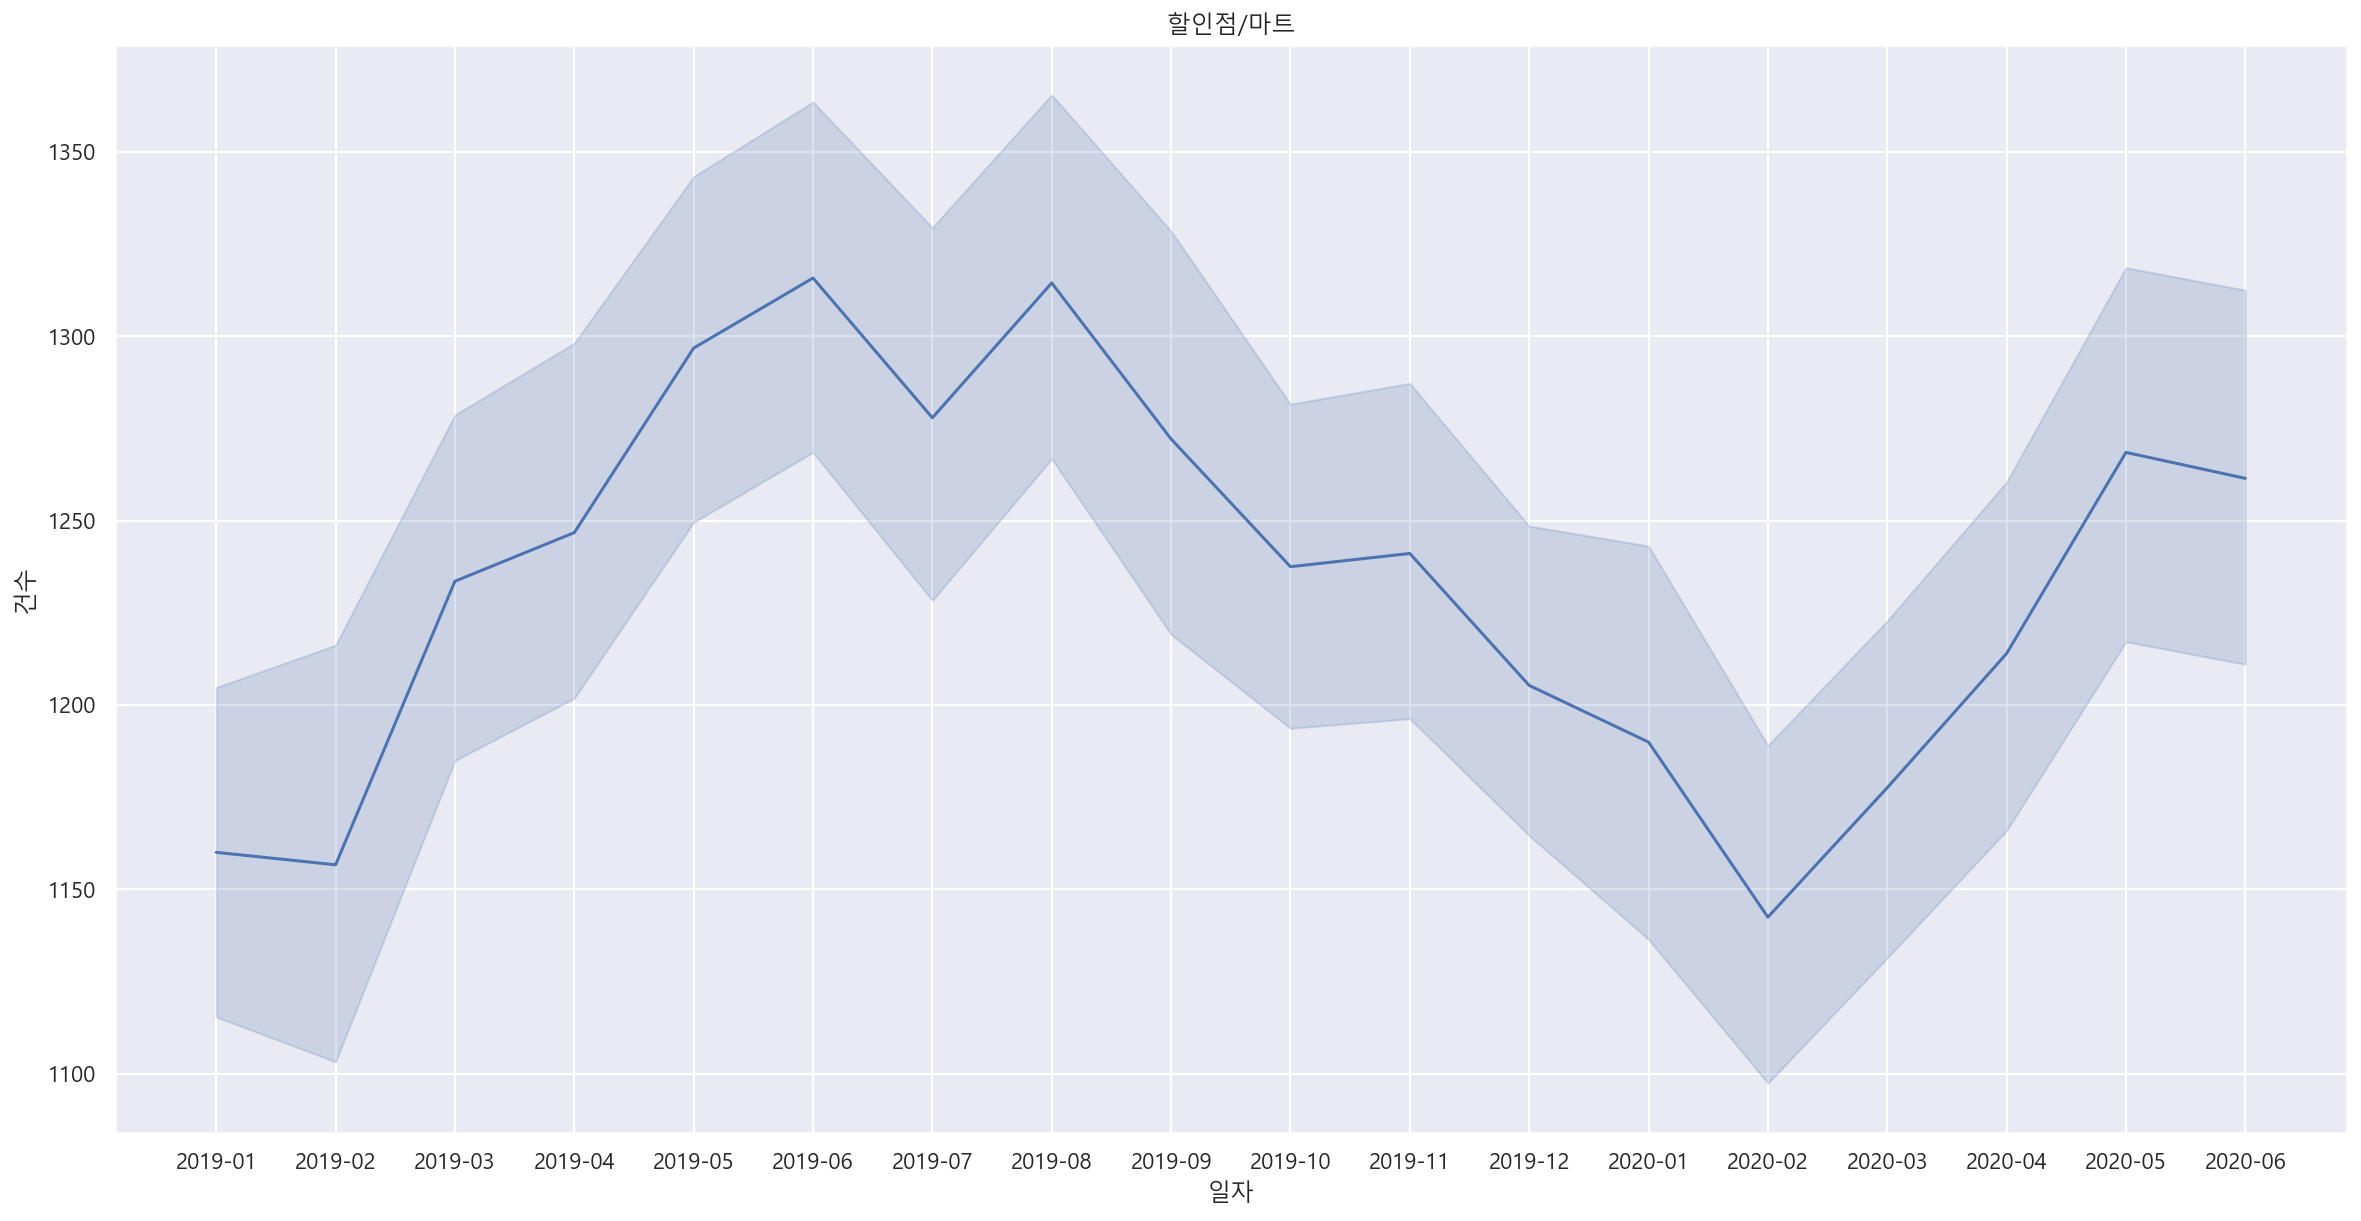

In [25]:
card_copy=card.copy()
n=0
for i in spe_list: 
    card_copy=card_copy[card_copy['업종']==i]
    card_copy['일자']=pd.to_datetime(card_copy['일자'].astype(str))
    card_copy['일자']= card_copy['일자'].apply(lambda x: str(x)[:7])

    plt.figure(figsize=(20,10))
    plt.title(i)
    sns.lineplot(x='일자',y='건수',data=card_copy)
    plt.savefig('spe'+str(n)+'.png')
    plt.show()
    card_copy=card.copy()
    n+=1

# K-means 사용

In [ ]:
# 최적화 군집 갯수
elbow(sh_card, 8, seed=seed)

* 신한+삼성 데이터

In [26]:
seed=607

In [27]:
for i in range(len(spe_list)):
    card['업종_'+spe_list[i]]= card['업종'].apply(lambda x: 1 if x==spe_list[i] else 0 )
    
card=card.drop(columns=['업종'])
card['일자']=card['일자'].apply(lambda x : pd.to_datetime(str(x)))
card['일자']=card['일자'].astype(np.int64)

km = KMeans(n_clusters=3, n_jobs=-1, random_state=seed)
km.fit(card)
res= km.predict(card)

In [28]:
card_cl_0=card[res==0].copy()
card_cl_0['일자']=pd.to_datetime(card_cl_0['일자'])
card_cl_0

,일자,성별,연령,건수,업종_가전/가구,업종_가정생활/서비스,업종_교육/학원,업종_미용,업종_백화점/상품권/아울렛,업종_스포츠/문화/레저,업종_여행/교통,업종_요식/유흥,업종_의료,업종_자동차,업종_주유,업종_패션/잡화,업종_편의점,업종_할인점/마트
51100,2020-01-01,1,20,36.4,1,0,0,0,0,0,0,0,0,0,0,0,0,0
51101,2020-01-01,1,30,40.4,1,0,0,0,0,0,0,0,0,0,0,0,0,0
51102,2020-01-01,1,40,42.3,1,0,0,0,0,0,0,0,0,0,0,0,0,0
51103,2020-01-01,1,50,30.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
51104,2020-01-01,1,60,14.1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76575,2020-06-30,0,20,643.7,0,0,0,0,0,0,0,0,0,0,0,0,0,1
76576,2020-06-30,0,30,1070.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
76577,2020-06-30,0,40,1543.6,0,0,0,0,0,0,0,0,0,0,0,0,0,1
76578,2020-06-30,0,50,1475.9,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [29]:
card_cl_1=card[res==1].copy()
card_cl_1['일자']=pd.to_datetime(card_cl_1['일자'])
card_cl_1

,일자,성별,연령,건수,업종_가전/가구,업종_가정생활/서비스,업종_교육/학원,업종_미용,업종_백화점/상품권/아울렛,업종_스포츠/문화/레저,업종_여행/교통,업종_요식/유흥,업종_의료,업종_자동차,업종_주유,업종_패션/잡화,업종_편의점,업종_할인점/마트
0,2019-01-01,1,20,38.3,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2019-01-01,1,30,39.1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2019-01-01,1,40,40.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2019-01-01,1,50,28.3,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2019-01-01,1,60,11.8,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25615,2019-07-02,0,20,784.9,0,0,0,0,0,0,0,0,0,0,0,0,0,1
25616,2019-07-02,0,30,1345.5,0,0,0,0,0,0,0,0,0,0,0,0,0,1
25617,2019-07-02,0,40,1864.8,0,0,0,0,0,0,0,0,0,0,0,0,0,1
25618,2019-07-02,0,50,1609.2,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [30]:
card_cl_2=card[res==2].copy()
card_cl_2['일자']=pd.to_datetime(card_cl_2['일자'])
card_cl_2

,일자,성별,연령,건수,업종_가전/가구,업종_가정생활/서비스,업종_교육/학원,업종_미용,업종_백화점/상품권/아울렛,업종_스포츠/문화/레저,업종_여행/교통,업종_요식/유흥,업종_의료,업종_자동차,업종_주유,업종_패션/잡화,업종_편의점,업종_할인점/마트
25620,2019-07-03,1,20,60.3,1,0,0,0,0,0,0,0,0,0,0,0,0,0
25621,2019-07-03,1,30,65.4,1,0,0,0,0,0,0,0,0,0,0,0,0,0
25622,2019-07-03,1,40,72.4,1,0,0,0,0,0,0,0,0,0,0,0,0,0
25623,2019-07-03,1,50,64.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
25624,2019-07-03,1,60,36.5,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51095,2019-12-31,0,20,855.5,0,0,0,0,0,0,0,0,0,0,0,0,0,1
51096,2019-12-31,0,30,1440.5,0,0,0,0,0,0,0,0,0,0,0,0,0,1
51097,2019-12-31,0,40,2071.1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
51098,2019-12-31,0,50,1959.8,0,0,0,0,0,0,0,0,0,0,0,0,0,1


* 성별 제거 데이터

In [ ]:
card2=card.groupby(['일자','업종','연령']).sum().reset_index()
for i in range(len(spe_list)):
    card2['업종_'+spe_list[i]]= card2['업종'].apply(lambda x: 1 if x==spe_list[i] else 0 )
    
card2=card2.drop(columns=['업종'])
card2['일자']=card2['일자'].apply(lambda x : pd.to_datetime(str(x)))
card2['일자']=card2['일자'].astype(np.int64)
card2=card2.drop(columns=['성별'])

km = KMeans(n_clusters=3, n_jobs=-1, random_state=seed)
km.fit(card2)
res= km.predict(card2)

In [ ]:
km = KMeans(n_clusters=3, n_jobs=-1, random_state=seed)
km.fit(card2)
res= km.predict(card2)

* 산업끼리 그룹화 데이터

In [ ]:
card3=card.groupby(['일자','업종','성별']).sum().reset_index().drop(columns=['연령'])

for i in range(len(spe_list)):
    card3['업종_'+spe_list[i]]= card3['업종'].apply(lambda x: 1 if x==spe_list[i] else 0 )
    
card3=card3.drop(columns=['업종'])
card3['일자']=card3['일자'].apply(lambda x : pd.to_datetime(str(x)))
card3['일자']=card3['일자'].astype(np.int64)
# card3=card3.drop(columns=['성별'])

In [ ]:
km = KMeans(n_clusters=3, n_jobs=-1, random_state=seed)
km.fit(card3)
res= km.predict(card3)

* DBSCAN

In [ ]:
db= DBSCAN (eps=50, min_samples=5, n_jobs=-1)
res_db= db.fit_predict(card)
pd.Series(res_db).value_counts()
card[res_db!=-1]

## 신한카드로 세부 분석

In [36]:
shinhan_temp=Shinhancard[(Shinhancard['연령대별']=='60대')|(Shinhancard['연령대별']=='70대')].groupby(['일별','성별','업종']).sum().reset_index()
shinhan_temp['연령대별']='60대'
shinhan_temp=shinhan_temp[['일별','성별','연령대별','업종','카드이용건수(천건)']]

In [37]:
ref_Shinhancard=pd.concat([Shinhancard[Shinhancard['연령대별']<='50대'],shinhan_temp])
sh_card=ref_Shinhancard.copy()
sh_list=sh_card['업종'].unique().tolist()

In [38]:
sh_card.columns=['일자','성별','연령','업종','건수']
sh_card=sh_card[['일자','업종','성별','연령','건수']]

In [39]:
sh_card['연령']=sh_card['연령'].apply(lambda x: x[:2])
sh_card['일자']=sh_card['일자'].apply(lambda x: int(str(x)[:7]))
sh_card_gp=sh_card.groupby(['일자','업종','성별','연령']).sum().reset_index().copy()

# sh_card_gp['성별'] = sh_card_gp['성별'].apply(lambda x: 'M' if x==1 else 'F').copy()
# sh_card_gp['연령'] = sh_card_gp['연령'].apply(lambda x: str(x)+'대').copy()

sh_card_gp=sh_card_gp.groupby(['일자','업종','연령']).sum().reset_index()

sh_card_gp['건수']=np.round(sh_card_gp['건수']).astype(int)
sh_card_all=sh_card_gp.groupby(['일자','연령']).sum().reset_index()

### Kmeans 
* 위와 비슷

In [ ]:
sh_card['성별'] = sh_card['성별'].apply(lambda x: 1 if x=='M' else 0)
sh_card['연령대별'] = sh_card['연령대별'].apply(lambda x: int(x[:2]))

for i in range(len(sh_list)):
    sh_card['업종_'+sh_list[i]]= sh_card['업종'].apply(lambda x: 1 if x==sh_list[i] else 0 )
    
sh_card=sh_card.drop(columns=['업종'])
sh_card['일별']=pd.to_datetime(sh_card['일별'].astype(str))
sh_card['일별']=sh_card['일별'].astype(np.int64)

km = KMeans(n_clusters=3, n_jobs=-1, random_state=seed)
km.fit(sh_card)
res= km.predict(sh_card)

### 상관계수 살펴보기

#### 1

In [40]:
for i in range(len(sh_card_all)):
    if str(sh_card_all['일자'][i])[-1]=='3':
        sh_card_all.drop(i, inplace=True)
        
for i in range(len(sh_card_gp)):
    if str(sh_card_gp['일자'][i])[-1]=='3':
        sh_card_gp.drop(i, inplace=True)
        
sh_card_all=sh_card_all.reset_index()
sh_card_gp=sh_card_gp.reset_index()

In [41]:
def save_corr_sh(k):
    for i in range(len(k)):
        plt.figure(figsize=(20,10))
        print(sh_list[i])
        before_sh_card_all=sh_card_all[(sh_card_all['일자']<2020010)&(sh_card_all['일자']>=2019070)]
        before_sh_card_gp=sh_card_gp[(sh_card_gp['일자']<2020010)&(sh_card_gp['일자']>=2019070)]
        all_before=before_sh_card_all[before_sh_card_all['업종']==sh_list[i]]
        all_before['건수_정규화']=score_normalize(np.array(before_sh_card_all[before_sh_card_all['업종']==sh_list[i]]['건수']).reshape(-1,1))
        for j in age_list:
            all_before[str(j)+'_정규화']=score_normalize(np.array(before_sh_card_gp[(before_sh_card_gp['연령']==j)&(before_sh_card_gp['업종']==sh_list[i])]['건수']).reshape(-1,1))
        set_all_before=all_before[['건수_정규화','20_정규화','30_정규화','40_정규화','50_정규화','60_정규화']]
        mask = np.triu(np.ones_like(set_all_before.corr(), dtype=np.bool))

        plt.subplot(1,2,1)
        plt.title(sh_list[i]+' 코로나 전')
        sns.heatmap(set_all_before.corr(), annot=True, cmap="Blues", mask=mask)

        after_sh_card_all=sh_card_all[(sh_card_all['일자']>=2020010)]
        after_sh_card_gp=sh_card_gp[(sh_card_gp['일자']>=2020010)]
        all_after=after_sh_card_all[after_sh_card_all['업종']==sh_list[i]]
        all_after['건수_정규화']=score_normalize(np.array(after_sh_card_all[after_sh_card_all['업종']==sh_list[i]]['건수']).reshape(-1,1))
        for k in age_list:
            all_after[str(k)+'_정규화']=score_normalize(np.array(after_sh_card_gp[(after_sh_card_gp['연령']==k)&(after_sh_card_gp['업종']==sh_list[i])]['건수']).reshape(-1,1))
        select_all_after=all_after[['건수_정규화','20_정규화','30_정규화','40_정규화','50_정규화','60_정규화']]
        mask = np.triu(np.ones_like(select_all_after.corr(), dtype=np.bool))

        plt.subplot(1,2,2)
        plt.title('코로나 후')
        sns.heatmap(select_all_after.corr(), annot=True, cmap="Blues", mask=mask)
        plt.savefig('sh_save'+str(i)+'.png')
        plt.show()

#### 2

In [ ]:
sh_card_all=sh_card_all.groupby(['일자']).sum().reset_index()
sh_card_all=sh_card_all[(sh_card_all['일자']>=2019070)&(sh_card_all['일자']<=2020010)]
sh_card_all['건수_정규화']=score_normalize(np.array(sh_card_all['건수']).reshape(-1,1))

In [ ]:
sh_card=sh_card[(sh_card['일자']>=2019070)&(sh_card['일자']<=2020010)]
sh_per_spe=sh_card.groupby(['일자','업종']).sum().reset_index()

In [ ]:
plt.figure(figsize=(40,20))
for i in sh_list:
    sh_card_all[i]=score_normalize(np.array(sh_per_spe[sh_per_spe['업종']==i]['건수']).reshape(-1,1))

mask = np.triu(np.ones_like(sh_card_all.corr(), dtype=np.bool))
sns.heatmap(sh_card_all.corr(), annot=True, cmap="Reds", mask=mask)
plt.show()

# Online Data

### **변수 자동 생성 대신 list or dict로**

In [ ]:
sh_list = []
for i in spe_list :
    sh_list.append(sh_card[sh_card['업종'] == i])

In [ ]:
sh_dic = {}
for i in spe_list :
    sh_dic[i] = sh_card[sh_card['업종'] == i]

In [ ]:
corp=pd.read_csv(path+'/G2_df.csv')

In [ ]:
cate_list=corp['카테고리명'].unique().tolist()
month_list=corp['구매월'].unique().tolist()

In [ ]:
import copy

corp_list=[]
for i in cate_list:
    temp_list = []
    temp_df = corp[corp['카테고리명']==i]
    for j in month_list : temp_list.append(temp_df[temp_df['구매월'] == j])
    corp_list.append(copy.deepcopy(temp_list))

In [ ]:
for i in range(len(cate_list)):
    for j in range(len(month_list)):
        corp_list[i][j]=corp_list[i][j].reset_index()
        corp_list[i][j]['비율']=corp_list[i][j]['구매수'].apply(lambda x: x/corp_list[i][j]['구매수'][1:].sum())
        corp_list[i][j]['비율']=corp_list[i][j]['비율'].apply(lambda x: x*corp_list[i][j]['구매수'][0])
        corp_list[i][j]['구매수']+=corp_list[i][j]['비율']
#         corp_list[i][j]=corp_list[i][j].drop([corp_list[i][j].columns[0], corp_list[i][j].columns[-1]])
new_corp = pd.concat([corp_list[i][j] for i in range(len(cate_list)) for j in range(len(month_list))]).copy()


In [ ]:
cop=new_corp[['구매월','카테고리명','고객나이','구매수']].copy()
cop=cop[cop['고객나이']!=0]
cop['구매수']=round(cop['구매수']).astype(int)

In [ ]:
cop=cop.reset_index()

In [ ]:
# elbow(cop, 8 ,seed=seed)

In [ ]:
cop['구매월']=pd.to_datetime(cop['구매월'].astype(str).apply(lambda x : x + '01')).map(dt.datetime.toordinal)

for i in range(len(cate_list)):
    cop['카테고리_'+cate_list[i]]= cop['카테고리명'].apply(lambda x: 1 if x==cate_list[i] else 0 )
    
cop=cop.drop(columns=['index','카테고리명'])
km = KMeans(n_clusters=3, n_jobs=-1, random_state=seed)
km.fit(cop)
res= km.predict(cop)

# cop['구매월']=cop['구매월'].map(dt.date.fromordinal)

In [ ]:
cop_20=cop[(cop['고객나이']==10)|(cop['고객나이']==20)].groupby(['구매월','카테고리명']).sum().reset_index()
cop=pd.concat([cop_20, cop[(cop['고객나이']>20)]])
cop=cop.drop(columns=['index'])

In [ ]:
cop

# 수치형-수치형 사이의 경향
* scatter_plot
* heatmap

In [ ]:
M_corper

In [ ]:
M_corper[M_corper['고객성별']!='없음'].sample(1000)

In [ ]:
seed=607

In [ ]:
ex1 = M_corper[M_corper['고객성별']!='없음'].sample(1000,random_state=seed).copy()

In [ ]:
ex1

In [ ]:
x = '구매수'
y = '구매금액'

plt.figure(figsize=(20,10))
sns.scatterplot(x=x,y=y,data=ex1,
                hue='고객성별',color='r', style='고객성별', 
                marker='x', s=200)
plt.xlabel(x,fontsize=30)
plt.ylabel(y,fontsize=30)
plt.legend(prop={'size': 30})
plt.title('Scatter plot',fontsize=30)
plt.grid(False)
# plt.savefig('test.jpg')
plt.show()

In [ ]:
sns.lmplot(x=x,y=y,data=ex1,
           hue='고객성별', palette=dict(F='g',M='m'),height=10)
plt.show() # palette 색
# 범위가 크면 클수록 쓰레기
# 선은 linear_regression 회귀선 

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
sns.scatterplot(x=x,y=y,data=ex1,color='r')

plt.subplot(2,3,2)
sns.scatterplot(x=x,y=y,data=ex1,color='b')

plt.subplot(2,3,3)
sns.scatterplot(x=x,y=y,data=ex1,color='g')

plt.subplot(2,3,4)
sns.scatterplot(x=x,y=y,data=ex1,color='y')

plt.subplot(2,3,5)
sns.scatterplot(x=x,y=y,data=ex1,color='k')

plt.subplot(2,3,6)
sns.scatterplot(x=x,y=y,data=ex1,color='w')

# plt.savefig('test.jpg')
plt.show()

* log로 줄여줌, 선형관계가 보임

In [ ]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=x,y=y,data=ex1,color='r')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
ex2=M_corper.copy()

In [ ]:
ex2.corr() # 0.7~1.0 엄청 강한 상관 관계, 0.5~0.7, 0.5밑은 의미가 좀 없음

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(ex2.corr())
plt.show()

# 범주형~수치형
* box_plot
* bar_plot

In [ ]:
ex3=M_corper.copy()

In [ ]:
ex3

In [ ]:
plt.figure(figsize=(20,10))
sns.boxplot(x="OS유형", y="구매금액", data=ex3)
plt.show()
# 상자에서 맨 밑에 상자가 25% 상자 맨 위가 75% 중간이 50% 상자rqr rqr-평균*1.5까지 표현해주는거
# rqr이 너무 작으면 데이터분석이 병신이거나 균일분포인거나 

In [ ]:
ex3.describe()
# 25% 1분위수 50% 제2분위수 75% 제3분위수

In [ ]:
ex3 = ex3[(ex3['구매금액']>0)&(ex3['구매금액']<1000000)].copy()

In [ ]:
plt.figure(figsize=(20,10))
sns.boxplot(x="OS유형", y="구매금액", data=ex3)
plt.show()

# Bar Plot

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(x="OS유형", y="구매금액", data=ex3)
# 구매금액의 평균
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(x="OS유형", y="구매금액", data=ex3, hue='고객성별')
# 구매금액의 평균
plt.show()

# 변수의 고유 특성
* 히스토그램

In [ ]:
ex4=M_corper.copy()

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
sns.distplot(ex4['구매수'][ex4['고객성별']=='F'],bins=np.arange(100,1000,100),kde=False,color='r')
# kde 선 그리기, rug 밀도

plt.subplot(2,1,2)
sns.distplot(ex4['구매수'][ex4['고객성별']=='M'],bins=np.arange(1000,30000,1000),kde=True,color='b',rug=True)

plt.show()

# Line Plot(Time Series)

In [ ]:
ex5=M_corper.copy()

In [ ]:
ex5=ex5[(ex5['고객나이']>10)&(ex5['고객나이']<80)].copy()

* max, min, mean, count

In [ ]:
ex5=ex5.groupby(['고객나이','구매날짜']).sum().reset_index().copy()

In [ ]:
# astype type 바꿔줌
# datetime은 int는 못 바꿔줌, astype만 바꿔줄 수 있다
ex5['구매날짜']=pd.to_datetime(ex5['구매날짜'].astype(str))

In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(x='구매날짜',y='구매금액',hue='고객나이',data=ex5)
plt.show()

# 데이터 특성

In [ ]:
Samsungcard

In [ ]:
Samsungcard['연령대'].apply(lambda x: int(x[:2]))

In [ ]:
Shinhancard

In [ ]:
Shinhancard['연령대별'].apply(lambda x: int(x[:2]))

# 삼성+신한 해주기

In [ ]:
Samsungcard['성별']=Samsungcard['성별'].apply(lambda x:1 if x=='남성' else 0)

In [ ]:
Samsungcard['성별']=Samsungcard['성별'].apply(lambda x:1 if x=='F' else 0)

In [ ]:
Gin_price=ori_Gin_price.copy()

In [ ]:
Gin_price['ym']=Gin_price['std_date'].apply(lambda x: int(str(x)[:7].replace('-',''))).copy()

In [ ]:
Gin_price['ym']

In [ ]:
Gin=Gin_price.groupby(['lgdng_cd','ym']).mean().reset_index().copy()

In [ ]:
Gin.head()

In [ ]:
Gin_trade_vol

In [ ]:
Gin=pd.merge(Gin, Gin_trade_vol, how='left', on=['lgdng_cd','ym']).copy()

In [ ]:
Gin

* Gin_loc 합쳐서 봐라

In [ ]:
Mbn_news

In [ ]:
kw = Mbn_news['keywords'][Mbn_news['keywords'].fillna('nan')!='nan'].tolist()

In [ ]:
vc = pd.Series([j for i in kw for j in i.split(',')]).value_counts()

In [ ]:
vc

# word2vec

In [ ]:
M_corper

In [ ]:
test = M_corper.copy()

In [ ]:
len(test['카테고리명'].unique())

In [ ]:
test['카테고리명'].unique()

In [ ]:
a='가공식품'

In [ ]:
cate_list=test['카테고리명'].unique().tolist()

In [ ]:
cate_list.index(a)

In [ ]:
test['카테고리명']=test['카테고리명'].apply(lambda x: cate_list.index(x))

In [ ]:
test

* 이렇게 0-63이 맞는가?
* K-means하면 대소관계를 줘도 괜찮음

In [ ]:
test['고객성별M']=test['고객성별'].apply(lambda x: 1 if x=='M' else 0)
test['고객성별F']=test['고객성별'].apply(lambda x: 1 if x=='F' else 0)

In [ ]:
test

In [ ]:
OS_list=test['OS유형'].unique().tolist()

In [ ]:
OS_list

In [ ]:
for i in range(len(OS_list)-1):
    test['OS유형_'+OS_list[i]]= test['OS유형'].apply(lambda x: 1 if x==OS_list[i] else 0 )

In [ ]:
test

In [ ]:
test['고객나이'].unique()

In [ ]:
test=test.drop(columns=['구매날짜','고객성별','OS유형']).copy()

In [ ]:
test

In [ ]:
# 군집수, CPU갯수(무조건 -1주셈), random_state=seed주면 됨
km = KMeans(n_clusters=3, n_jobs=-1, random_state=seed)


In [ ]:
km.fit(test)

In [ ]:
res= km.predict(test)

In [ ]:
test[res==1]

In [ ]:
test

In [ ]:
test2=test[test['고객나이']==20]

In [ ]:
test2

In [ ]:
km2=KMeans(n_clusters=4, n_jobs=-1, random_state=seed)

In [ ]:
km2.fit(test2)

In [ ]:
res2=km2.predict(test2)

* 케이민즈는 다차원에서 거리가 가까운 친구들을 말한다

In [ ]:
test2[res2==0]

In [ ]:
# DBscan 밀도 기반, 반지름을 주고 그 안에 몇개가 들어오는지 주어줌 
# 군집화 갯수는 안주고 반지름이랑 갯수만 준다

In [ ]:
# method / kmeans 더 효율적으로 쓰는 것 
# def elbow(X,n,seed=1192):
#     sse = []
#     for i in range(1,n+1):
#         print("\r",i,"/",n,end='') # r: rewrite, end: 줄 바뀜 없애기
#         km = KMeans(n_clusters=i,init='k-means++',random_state=seed)
#         km.fit(X)
#         sse.append(km.inertia_)
#     plt.figure(figsize=(20,10))
#     plt.plot(range(1,n+1),sse,marker='o')
#     plt.ylabel("SSE")
#     plt.show()

In [ ]:
# elbow(test, 10, seed=seed)

In [ ]:
# 반지름, 거기 들어가야하는 갯수, 
db= DBSCAN (eps=1, min_samples=5, n_jobs=-1)

In [ ]:
res_db= db.fit_predict(test)

In [ ]:
pd.Series(res_db).value_counts()

In [ ]:
test[res_db!=1]

In [ ]:
db= DBSCAN (eps=1, min_samples=5, n_jobs=-1)
res_db= db.fit_predict(test)
pd.Series(res_db).value_counts()
test[res_db!=1]